In [1]:
from func import *

In [2]:
# Example tsv files
datasets = {
            'cnv': 'CNV_processedDat.txt',
            'mrna': 'mRNA_processedDat.txt',
            'prot': 'PROT_processedDat.txt'
}
        
labels = 'TCGA_BRCA_subtypes.txt'

Note: This notebook is old and used for my COMP401 paper. There are some errors I made that are fixed, see breast_cancer.ipynb.

In [3]:
_metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}

Loading the data:

In [4]:
data = {}
target = {}

train_data = {}
train_target = {}

eval_data = {}
eval_target = {}

for modality in datasets:
    data[modality], target[modality] = load_data(datasets[modality], labels)
    train_data[modality], eval_data[modality], train_target[modality], eval_target[modality] = train_test_split(data[modality], target[modality], test_size=0.2, train_size=0.8)

Setting up the pipelines:

In [6]:
pipe_list = {}

# Setting up the pipes
for modality in datasets:
    pipes = {}

    for model in estimators:
        pipe=Pipeline(steps=[('data_prep',transformer),model])
        pipes[pipe.steps[1][0]]=pipe

    pipe_list[modality] = pipes

In [10]:
print(target['prot'].value_counts()[0])
print(target['prot'].value_counts()[1])
print(target['prot'].value_counts()[2])
print(target['prot'].value_counts()[3])

24
18
29
32


# Individual Model Scores

## Correlation Between Models:

In [10]:
ensemble_results_list = {}

for modality in datasets:
    ensemble_results=pd.DataFrame()
    print(modality)
    for name,pipe in pipe_list[modality].items():
        pipe.fit(train_data[modality], train_target[modality])
        ensemble_results[name]=pipe.predict(eval_data[modality])
    
    ensemble_results_list[modality] = ensemble_results

cnv


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


mrna
prot


<AxesSubplot: >

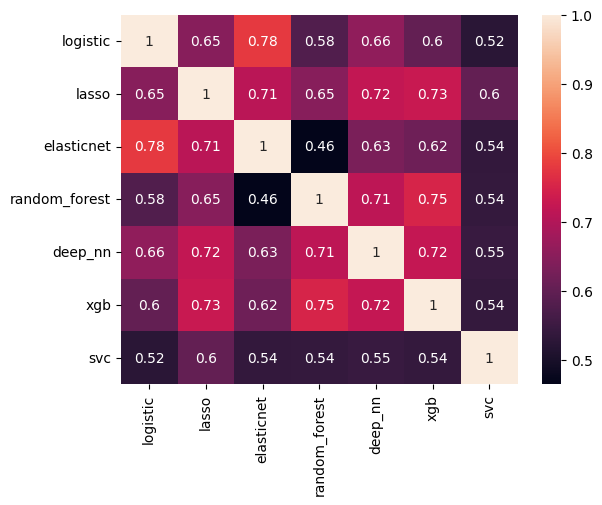

In [16]:
sns.heatmap(ensemble_results_list['cnv'].corr(),annot=True)

<AxesSubplot: >

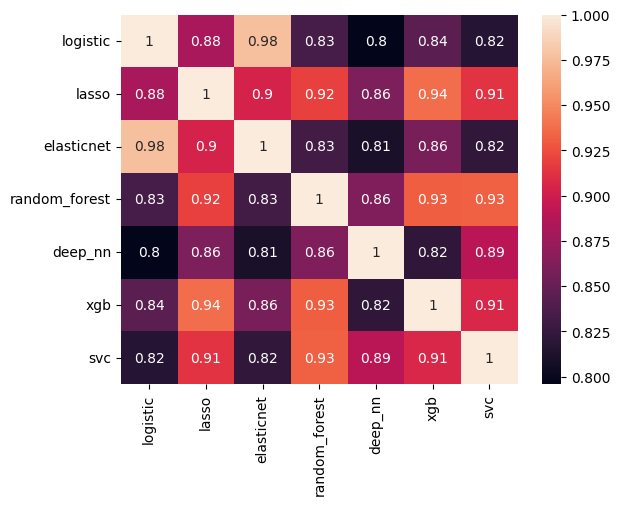

In [17]:
sns.heatmap(ensemble_results_list['mrna'].corr(),annot=True)

<AxesSubplot: >

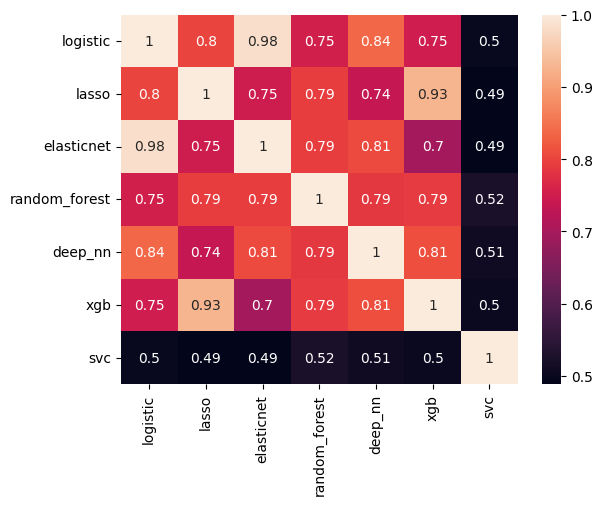

In [15]:
sns.heatmap(ensemble_results_list['prot'].corr(),annot=True)

## Metrics:

In [7]:
col_names = ['model', 'f1', 'accuracy']
metrics = []
cross_val_list = {}
scorer_lists = {}

# Finding 5-fold cross-validated metrics for each model, for each dataset
for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)

    scorers = []

    for name, pipe in tqdm(pipe_list[modality].items()):
        
        cv = KFold(n_splits=5, random_state=1, shuffle=True)

        scores = cross_validate(pipe, data[modality], target[modality], scoring = _metrics, cv=cv)
        scorers.append(scores)
        
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores['test_f1'].mean(), scores['test_f1'].std()), "%0.3f +/- %0.3f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val
    scorer_lists[modality] = scorers

100%|██████████| 7/7 [00:40<00:00,  5.82s/it]


In [8]:
# Show scores
display(cross_val_list['cnv']), display(cross_val_list['mrna']), display(cross_val_list['prot'])

,model,f1,accuracy
0,logistic,0.635 +/- 0.036,0.645 +/- 0.033
1,lasso,0.668 +/- 0.051,0.678 +/- 0.049
2,elasticnet,0.579 +/- 0.050,0.581 +/- 0.044
3,random_forest,0.655 +/- 0.062,0.677 +/- 0.057
4,deep_nn,0.591 +/- 0.062,0.599 +/- 0.056
5,xgb,0.687 +/- 0.055,0.701 +/- 0.052
6,svc,0.435 +/- 0.071,0.543 +/- 0.059


,model,f1,accuracy
0,logistic,0.833 +/- 0.034,0.831 +/- 0.035
1,lasso,0.843 +/- 0.036,0.841 +/- 0.039
2,elasticnet,0.802 +/- 0.028,0.797 +/- 0.033
3,random_forest,0.826 +/- 0.022,0.831 +/- 0.020
4,deep_nn,0.802 +/- 0.052,0.799 +/- 0.054
5,xgb,0.856 +/- 0.020,0.857 +/- 0.022
6,svc,0.806 +/- 0.029,0.817 +/- 0.025


,model,f1,accuracy
0,logistic,0.617 +/- 0.162,0.622 +/- 0.156
1,lasso,0.655 +/- 0.126,0.660 +/- 0.127
2,elasticnet,0.653 +/- 0.116,0.650 +/- 0.126
3,random_forest,0.583 +/- 0.058,0.610 +/- 0.075
4,deep_nn,0.480 +/- 0.050,0.506 +/- 0.063
5,xgb,0.595 +/- 0.080,0.612 +/- 0.088
6,svc,0.552 +/- 0.073,0.583 +/- 0.081


(None, None, None)

In [9]:
estimator_names = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc']

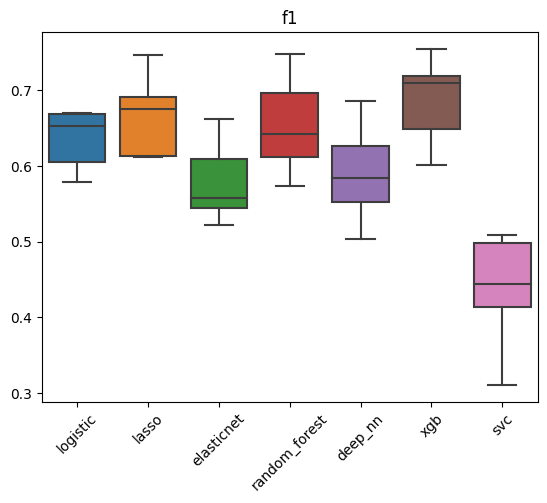

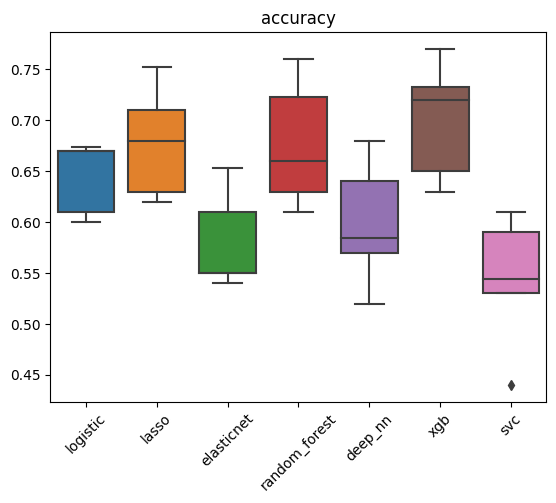

In [10]:
plot_scores(estimator_names, scorer_lists['cnv'])

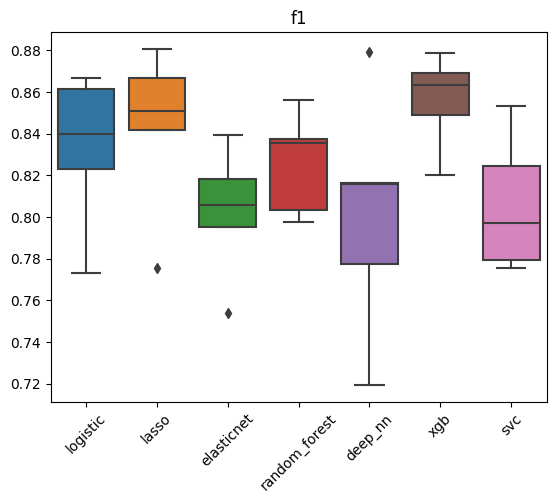

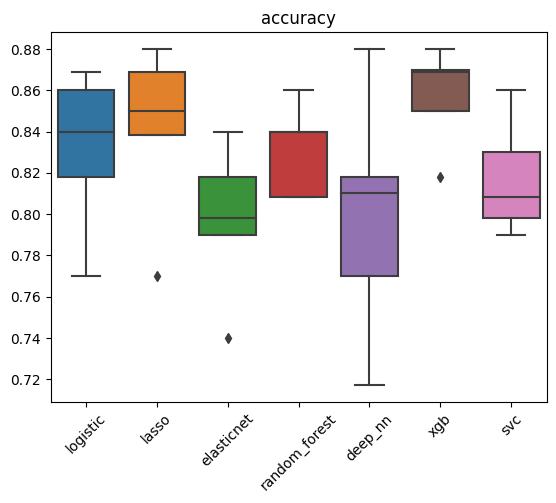

In [11]:
plot_scores(estimator_names, scorer_lists['mrna'])

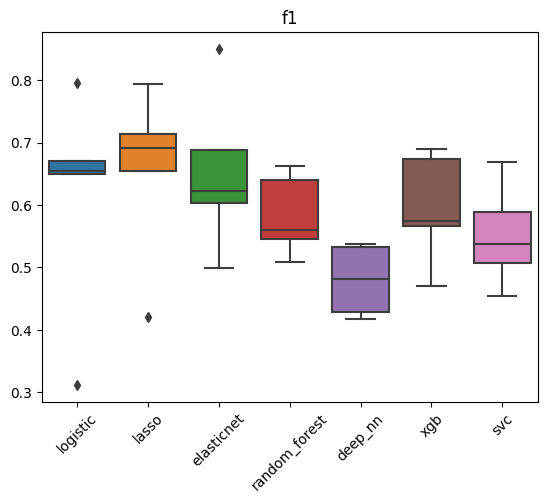

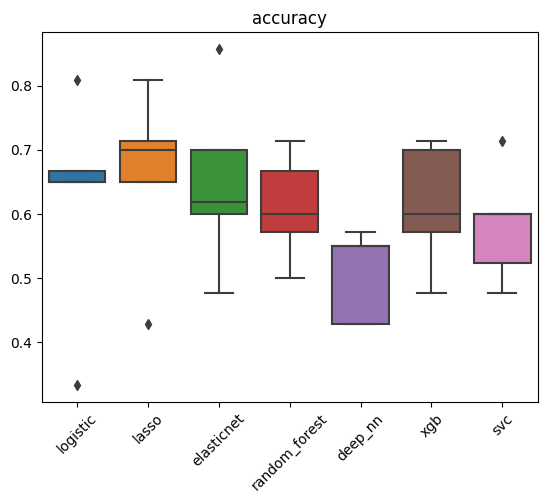

In [12]:
plot_scores(estimator_names, scorer_lists['prot'])

# Stacking Ensemble

### Logistic Regression as Meta Estimator:

In [5]:
# get a stacking ensemble of models
def trainStackingModel(pipes, final_estimator, data, target, metrics, cv):

    # Create the transformer to impute missing values
    imputer = SimpleImputer(strategy='mean')

    level1 = Pipeline(steps=[('prep', imputer), ('lr', final_estimator)])
    
     # calculating scores
    cv = KFold(n_splits=cv, random_state=1, shuffle=True)
    
    # define the stacking ensemble
    model = Pipeline(steps=[('data_prep',transformer),('stacking',StackingClassifier(estimators=pipes, final_estimator=level1, cv=cv))])

    scores = cross_validate(model, data, target, scoring=metrics, cv=cv, n_jobs=-1, error_score='raise')

    return model, scores

We will run the Stacking Classifier on the entire dataset, to get ensemble scores for each modality (5-fold cross validation).

In [13]:
col_names = ['model', 'f1', 'accuracy']
stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

for modality in datasets:
    print("dataset: " + modality)

    stacking_model[modality], scores[modality] = trainStackingModel(estimators, LogisticRegression(), data[modality], target[modality], metrics=_metrics, cv=5)

    stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv


/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
/opt/tljh/user/lib/python3.9/site-packages/sk

dataset: mrna


/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


dataset: prot


In [14]:
stacking_metrics

,model,f1,accuracy
0,cnv,0.698 +/- 0.055,0.714 +/- 0.059
1,mrna,0.853 +/- 0.028,0.853 +/- 0.028
2,prot,0.571 +/- 0.113,0.593 +/- 0.115


In [15]:
modalities=['cnv', 'mRNA', 'prot']
scorers = []
scorers.append(scores['cnv'])
scorers.append(scores['mrna'])
scorers.append(scores['prot'])

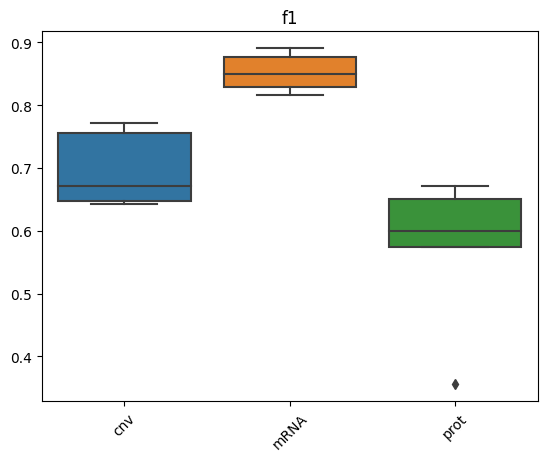

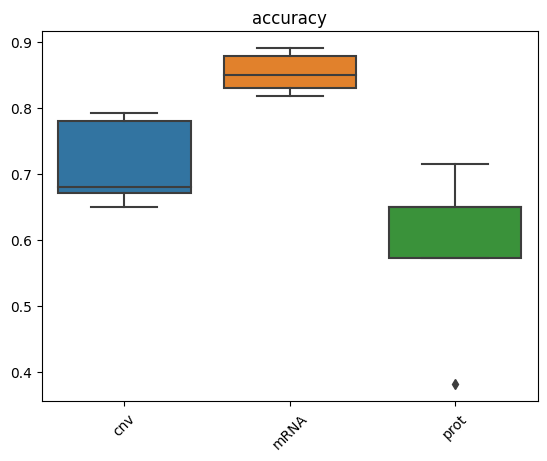

In [16]:
plot_scores(modalities, scorers)

In [17]:
estimator_lists = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc', 'stacking']

scorer_lists['cnv'].append(scores['cnv'])
scorer_lists['mrna'].append(scores['mrna'])
scorer_lists['prot'].append(scores['prot'])

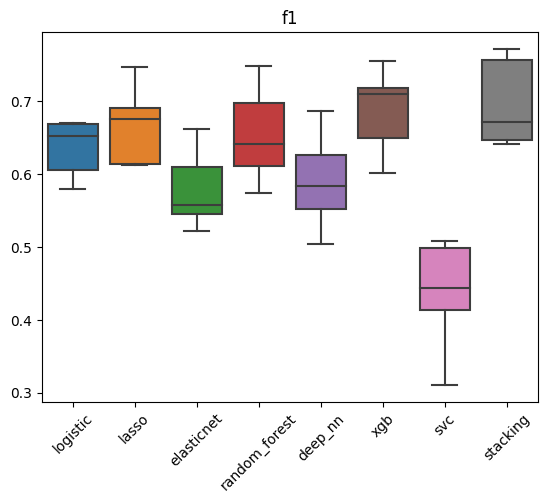

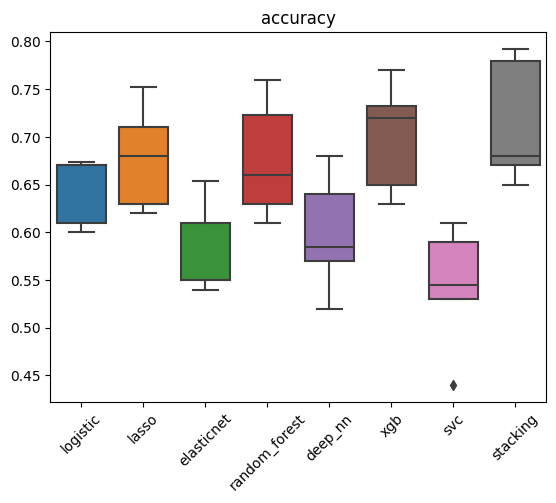

In [18]:
plot_scores(estimator_lists, scorer_lists['cnv'])

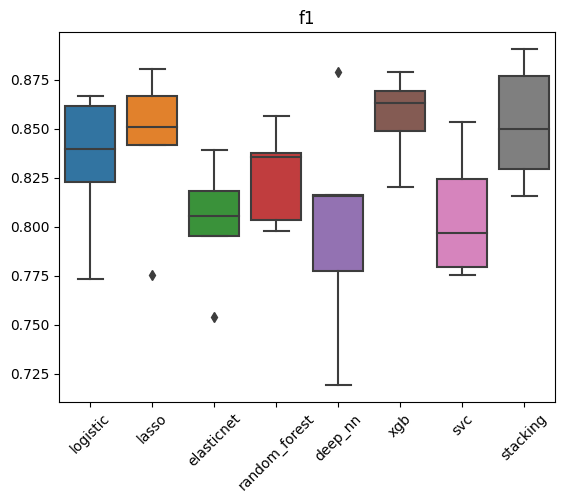

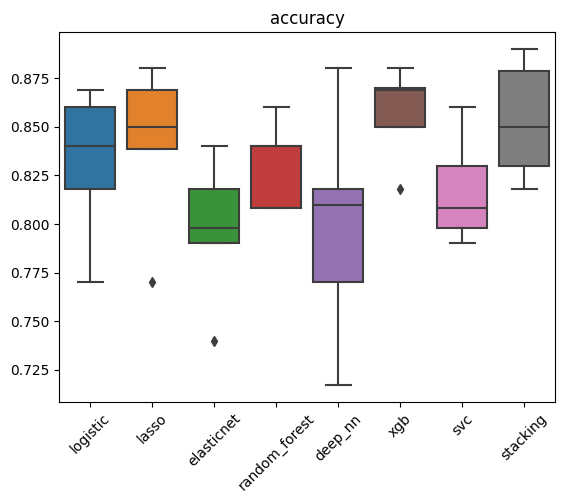

In [19]:
plot_scores(estimator_lists, scorer_lists['mrna'])

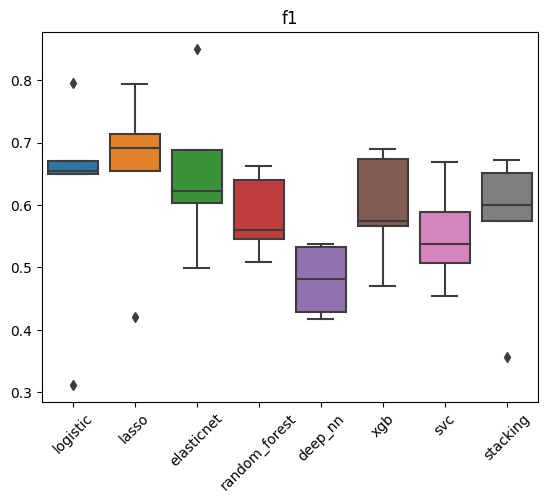

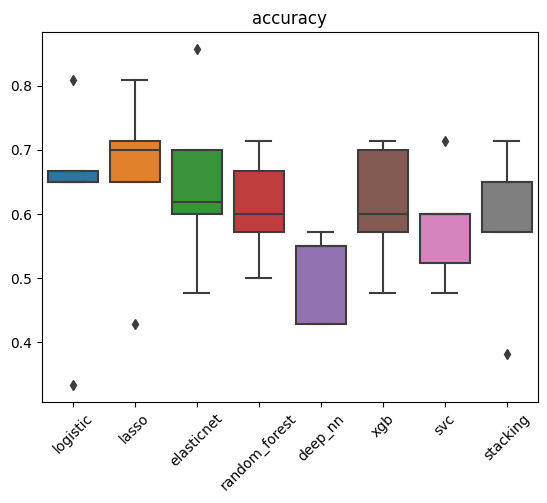

In [20]:
plot_scores(estimator_lists, scorer_lists['prot'])

# Reduced Features via SelectFromModel

In [5]:
# Setting up new results df
data_reduced = {}
col_names = ['model', 'f1', 'accuracy']
reduced_metrics = pd.DataFrame(columns=col_names)

In [6]:
# Reducing featuers for each modality, using L2 regularization
for modality in datasets:
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    
    clf = LogisticRegressionCV(penalty='l2', cv=cv)

    # Use SelectFromModel to select the most important features based on the L2 regularization
    selector = SelectFromModel(clf)
    selector.fit(data[modality], target[modality])
    selected_feats = data[modality].columns[(selector.get_support())]
    
    print(modality)
    print('Total features: {}'.format((data[modality].shape[1])))
    print('selected features: {}'.format(len(selected_feats)))
    
    # Creating reduced dataset
    data_reduced[modality]=data[modality][selected_feats]


cnv
Total features: 18799
selected features: 7991
mrna
Total features: 17939
selected features: 6428
prot
Total features: 8092
selected features: 3121


### Individual Models

In [29]:
metrics = []
cross_val_list = {}
scorer_lists = {}

# Finding 5-fold cross-validated metrics for each model, for each dataset
for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)

    scorers = []
    
    cv = KFold(n_splits=5, random_state=1, shuffle=True)

    for name, pipe in tqdm(pipe_list[modality].items()):

        scores = cross_validate(pipe, data_reduced[modality], target[modality], scoring = _metrics, cv=cv)
        scorers.append(scores)
        
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores['test_f1'].mean(), scores['test_f1'].std()), "%0.3f +/- %0.3f" % (scores['test_accuracy'].mean(), scores['test_accuracy'].std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val
    scorer_lists[modality] = scorers

100%|██████████| 7/7 [00:48<00:00,  6.91s/it]


In [30]:
# Show scores
display(cross_val_list['cnv']), display(cross_val_list['mrna']), display(cross_val_list['prot'])

,model,f1,accuracy
0,logistic,0.721 +/- 0.042,0.726 +/- 0.036
1,lasso,0.720 +/- 0.048,0.730 +/- 0.048
2,elasticnet,0.658 +/- 0.040,0.657 +/- 0.033
3,random_forest,0.674 +/- 0.048,0.691 +/- 0.044
4,deep_nn,0.680 +/- 0.065,0.686 +/- 0.062
5,xgb,0.696 +/- 0.054,0.707 +/- 0.056
6,svc,0.538 +/- 0.065,0.607 +/- 0.056


,model,f1,accuracy
0,logistic,0.924 +/- 0.020,0.924 +/- 0.020
1,lasso,0.883 +/- 0.020,0.882 +/- 0.021
2,elasticnet,0.879 +/- 0.043,0.874 +/- 0.048
3,random_forest,0.835 +/- 0.037,0.839 +/- 0.035
4,deep_nn,0.895 +/- 0.022,0.894 +/- 0.022
5,xgb,0.860 +/- 0.024,0.861 +/- 0.025
6,svc,0.860 +/- 0.021,0.865 +/- 0.019


,model,f1,accuracy
0,logistic,0.847 +/- 0.062,0.844 +/- 0.064
1,lasso,0.754 +/- 0.108,0.757 +/- 0.109
2,elasticnet,0.797 +/- 0.105,0.796 +/- 0.106
3,random_forest,0.631 +/- 0.128,0.659 +/- 0.114
4,deep_nn,0.765 +/- 0.106,0.766 +/- 0.101
5,xgb,0.633 +/- 0.087,0.641 +/- 0.086
6,svc,0.751 +/- 0.147,0.776 +/- 0.128


(None, None, None)

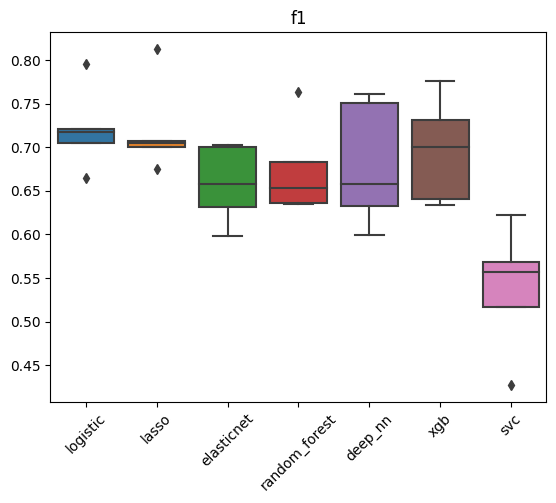

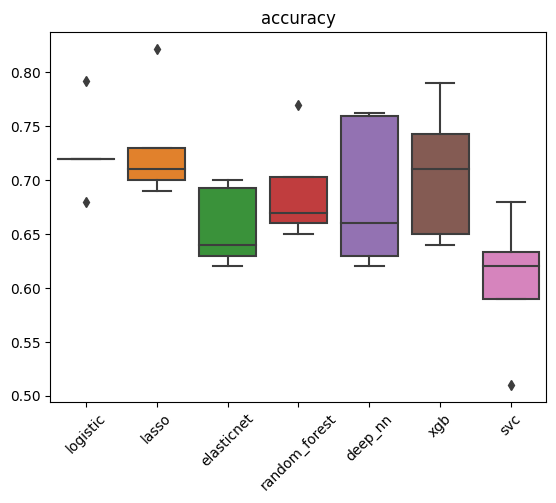

In [32]:
estimator_lists = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc']
plot_scores(estimator_lists, scorer_lists['cnv'])

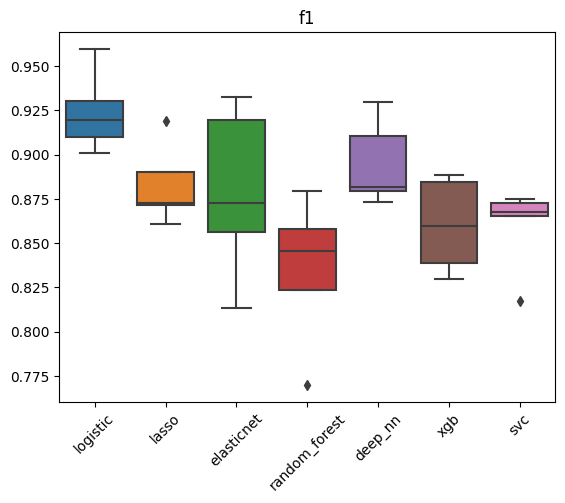

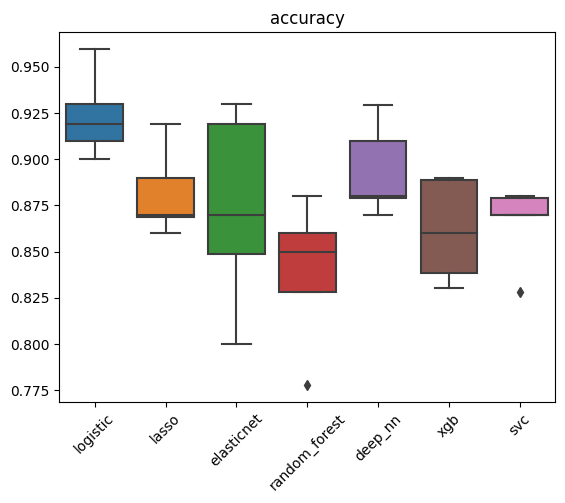

In [33]:
plot_scores(estimator_lists, scorer_lists['mrna'])

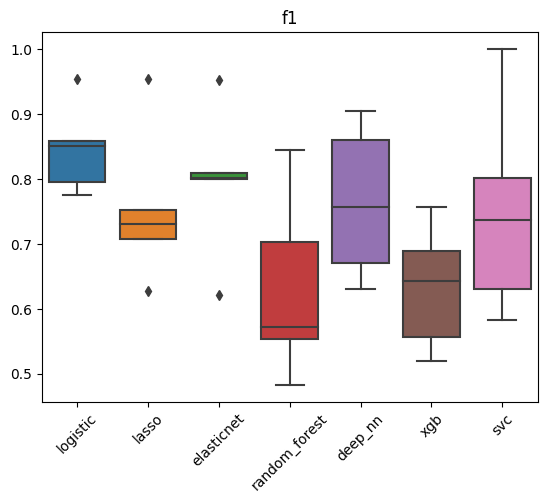

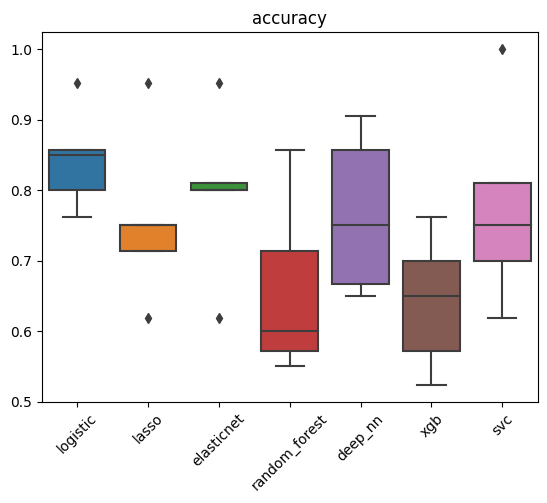

In [34]:
plot_scores(estimator_lists, scorer_lists['prot'])

### Ensemble

In [24]:
# TO DO: run this with all estimators
reduced_stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

selected_estimators = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'xgb', 'deep_nn', 'svc']

for modality in datasets:
    print("dataset: " + modality)
    
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators if x == name)]
    
    stacking_model[modality], scores[modality] = trainStackingModel(estimator_list, LogisticRegression(), data_reduced[modality], target[modality], metrics=_metrics, cv=5)

    reduced_stacking_metrics = pd.concat([reduced_stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv
dataset: mrna
dataset: prot


In [26]:
reduced_stacking_metrics

,model,f1,accuracy
0,cnv,0.725 +/- 0.033,0.738 +/- 0.038
1,mrna,0.916 +/- 0.023,0.916 +/- 0.023
2,prot,0.800 +/- 0.114,0.805 +/- 0.111


## Permutation Importance:

In [6]:
selected_estimators = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'xgb', 'deep_nn', 'svc']
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators if x == name)]

model, scores = trainStackingModel(estimator_list, LogisticRegression(), data['prot'], target['prot'], metrics=_metrics, cv=5)


NameError: name 'col_names' is not defined

In [8]:
pd.DataFrame([['prot', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)

,model,f1,accuracy
0,prot,0.571 +/- 0.113,0.593 +/- 0.115


In [9]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, train_data['prot'], train_target['prot'], n_repeats=10, random_state=1)
perm_sorted_idx = result.importances_mean.argsort()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
ax2.boxplot(
    result.importances[perm_sorted_idx].T,
    vert=False,
    labels=data.feature_names[perm_sorted_idx],
)
fig.tight_layout()
plt.show()

NotFittedError: This SimpleImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

## Reduced Estimators:

Ensemble model is still not better than best performing base estimator. We can try and improve this by trying combinations of estimators:

### Testing Combinations

In [25]:
from itertools import combinations
col_names = ['model', 'f1', 'accuracy']

In [26]:
def test_combos(names, data, target, estimators=estimators):
    stacking_metrics = pd.DataFrame(columns=col_names)

    combos=[]
    for L in range(2, len(names)+1):
        for subset in combinations(names, L):
            combos.append(list(subset))
            
    for combo in combos:
        estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in combo if x == name)]
        
        print('testing combo: ' + str(combo))
        stacking_model, combo_scores = trainStackingModel(estimator_list, LogisticRegression(), data, target, metrics=_metrics, cv=5)
        stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[str(combo), '%.3f +/- %.3f' %(np.mean(combo_scores['test_f1']), np.std(combo_scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(combo_scores['test_accuracy']), np.std(combo_scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    
    return stacking_metrics

In [40]:
# cnv estimators

estimator_names = ['logistic', 'lasso', 'xgb', 'deep_nn']

stacking_metrics = pd.DataFrame(columns=col_names)

stacking_metrics = test_combos(estimator_names, data_reduced['cnv'], target['cnv'])

testing combo: ['logistic', 'lasso']
testing combo: ['logistic', 'xgb']
testing combo: ['logistic', 'deep_nn']
testing combo: ['lasso', 'xgb']
testing combo: ['lasso', 'deep_nn']
testing combo: ['xgb', 'deep_nn']
testing combo: ['logistic', 'lasso', 'xgb']
testing combo: ['logistic', 'lasso', 'deep_nn']
testing combo: ['logistic', 'xgb', 'deep_nn']
testing combo: ['lasso', 'xgb', 'deep_nn']
testing combo: ['logistic', 'lasso', 'xgb', 'deep_nn']


In [41]:
stacking_metrics.sort_values('f1', ascending=False)

,model,f1,accuracy
8,"['logistic', 'xgb', 'deep_nn']",0.737 +/- 0.029,0.748 +/- 0.035
10,"['logistic', 'lasso', 'xgb', 'deep_nn']",0.736 +/- 0.025,0.748 +/- 0.031
1,"['logistic', 'xgb']",0.729 +/- 0.031,0.740 +/- 0.036
6,"['logistic', 'lasso', 'xgb']",0.729 +/- 0.030,0.740 +/- 0.036
0,"['logistic', 'lasso']",0.725 +/- 0.059,0.738 +/- 0.059
2,"['logistic', 'deep_nn']",0.722 +/- 0.061,0.736 +/- 0.056
9,"['lasso', 'xgb', 'deep_nn']",0.722 +/- 0.041,0.736 +/- 0.045
3,"['lasso', 'xgb']",0.722 +/- 0.033,0.736 +/- 0.037
4,"['lasso', 'deep_nn']",0.716 +/- 0.068,0.730 +/- 0.066
7,"['logistic', 'lasso', 'deep_nn']",0.716 +/- 0.062,0.730 +/- 0.059


In [38]:
# mRNA estimators

estimator_names = ['logistic', 'elasticnet', 'xgb', 'deep_nn', 'svc']

stacking_metrics = pd.DataFrame(columns=col_names)

stacking_metrics = test_combos(estimator_names, data_reduced['mrna'], target['mrna'])

testing combo: ['logistic', 'elasticnet']
testing combo: ['logistic', 'xgb']
testing combo: ['logistic', 'deep_nn']
testing combo: ['logistic', 'svc']
testing combo: ['elasticnet', 'xgb']
testing combo: ['elasticnet', 'deep_nn']
testing combo: ['elasticnet', 'svc']
testing combo: ['xgb', 'deep_nn']
testing combo: ['xgb', 'svc']
testing combo: ['deep_nn', 'svc']
testing combo: ['logistic', 'elasticnet', 'xgb']
testing combo: ['logistic', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'elasticnet', 'svc']
testing combo: ['logistic', 'xgb', 'deep_nn']
testing combo: ['logistic', 'xgb', 'svc']
testing combo: ['logistic', 'deep_nn', 'svc']
testing combo: ['elasticnet', 'xgb', 'deep_nn']
testing combo: ['elasticnet', 'xgb', 'svc']
testing combo: ['elasticnet', 'deep_nn', 'svc']
testing combo: ['xgb', 'deep_nn', 'svc']
testing combo: ['logistic', 'elasticnet', 'xgb', 'deep_nn']
testing combo: ['logistic', 'elasticnet', 'xgb', 'svc']
testing combo: ['logistic', 'elasticnet', 'deep_nn', '

In [39]:
stacking_metrics.sort_values('f1', ascending=False)

,model,f1,accuracy
2,"['logistic', 'deep_nn']",0.926 +/- 0.022,0.926 +/- 0.021
20,"['logistic', 'elasticnet', 'xgb', 'deep_nn']",0.926 +/- 0.018,0.926 +/- 0.018
21,"['logistic', 'elasticnet', 'xgb', 'svc']",0.925 +/- 0.020,0.926 +/- 0.020
11,"['logistic', 'elasticnet', 'deep_nn']",0.924 +/- 0.021,0.924 +/- 0.021
13,"['logistic', 'xgb', 'deep_nn']",0.922 +/- 0.025,0.922 +/- 0.025
10,"['logistic', 'elasticnet', 'xgb']",0.922 +/- 0.011,0.922 +/- 0.011
22,"['logistic', 'elasticnet', 'deep_nn', 'svc']",0.921 +/- 0.023,0.922 +/- 0.022
25,"['logistic', 'elasticnet', 'xgb', 'deep_nn', '...",0.921 +/- 0.019,0.922 +/- 0.018
1,"['logistic', 'xgb']",0.921 +/- 0.011,0.922 +/- 0.011
18,"['elasticnet', 'deep_nn', 'svc']",0.919 +/- 0.022,0.920 +/- 0.022


For mRNA, the best estimators are 'logistic' and 'deep_nn'.

In [27]:
# prot estimators

estimator_names = ['logistic', 'lasso', 'elasticnet', 'deep_nn', 'svc']

stacking_metrics = pd.DataFrame(columns=col_names)

stacking_metrics = test_combos(estimator_names, data_reduced['prot'], target['prot'])

testing combo: ['logistic', 'lasso']
testing combo: ['logistic', 'elasticnet']
testing combo: ['logistic', 'deep_nn']
testing combo: ['logistic', 'svc']
testing combo: ['lasso', 'elasticnet']
testing combo: ['lasso', 'deep_nn']
testing combo: ['lasso', 'svc']
testing combo: ['elasticnet', 'deep_nn']
testing combo: ['elasticnet', 'svc']
testing combo: ['deep_nn', 'svc']
testing combo: ['logistic', 'lasso', 'elasticnet']
testing combo: ['logistic', 'lasso', 'deep_nn']
testing combo: ['logistic', 'lasso', 'svc']
testing combo: ['logistic', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'elasticnet', 'svc']
testing combo: ['logistic', 'deep_nn', 'svc']
testing combo: ['lasso', 'elasticnet', 'deep_nn']
testing combo: ['lasso', 'elasticnet', 'svc']
testing combo: ['lasso', 'deep_nn', 'svc']
testing combo: ['elasticnet', 'deep_nn', 'svc']
testing combo: ['logistic', 'lasso', 'elasticnet', 'deep_nn']
testing combo: ['logistic', 'lasso', 'elasticnet', 'svc']
testing combo: ['logistic', 'l

In [28]:
stacking_metrics.sort_values('f1', ascending=False)

,model,f1,accuracy
1,"['logistic', 'elasticnet']",0.860 +/- 0.083,0.863 +/- 0.080
25,"['logistic', 'lasso', 'elasticnet', 'deep_nn',...",0.852 +/- 0.114,0.853 +/- 0.112
20,"['logistic', 'lasso', 'elasticnet', 'deep_nn']",0.852 +/- 0.114,0.853 +/- 0.112
23,"['logistic', 'elasticnet', 'deep_nn', 'svc']",0.842 +/- 0.103,0.843 +/- 0.101
13,"['logistic', 'elasticnet', 'deep_nn']",0.842 +/- 0.103,0.843 +/- 0.101
14,"['logistic', 'elasticnet', 'svc']",0.838 +/- 0.078,0.844 +/- 0.079
15,"['logistic', 'deep_nn', 'svc']",0.831 +/- 0.092,0.834 +/- 0.090
22,"['logistic', 'lasso', 'deep_nn', 'svc']",0.831 +/- 0.092,0.834 +/- 0.090
11,"['logistic', 'lasso', 'deep_nn']",0.831 +/- 0.092,0.834 +/- 0.090
3,"['logistic', 'svc']",0.830 +/- 0.075,0.834 +/- 0.074


For prot, the best performing combo is logistic and elasticnet.

In [7]:
# Dictionary of best estimators for each modality
selected_estimators = {
    'cnv': ['logistic', 'xgb', 'deep_nn'],
    'mrna': ['logistic', 'deep_nn'],
    'prot': ['logistic', 'elasticnet']
}

In [42]:
reduced_stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

for modality in datasets:
    print("dataset: " + modality)
    
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators[modality] if x == name)]
    
    stacking_model[modality], scores[modality] = trainStackingModel(estimator_list, LogisticRegression(), data_reduced[modality], target[modality], metrics=_metrics, cv=5)

    reduced_stacking_metrics = pd.concat([reduced_stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv
dataset: mrna
dataset: prot


In [43]:
reduced_stacking_metrics

,model,f1,accuracy
0,cnv,0.737 +/- 0.029,0.748 +/- 0.035
1,mrna,0.926 +/- 0.022,0.926 +/- 0.021
2,prot,0.860 +/- 0.083,0.863 +/- 0.080


In [44]:
estimator_lists = ['logistic', 'lasso', 'elasticnet', 'random_forest', 'deep_nn', 'xgb', 'svc', 'stacking']

scorer_lists['cnv'].append(scores['cnv'])
scorer_lists['mrna'].append(scores['mrna'])
scorer_lists['prot'].append(scores['prot'])

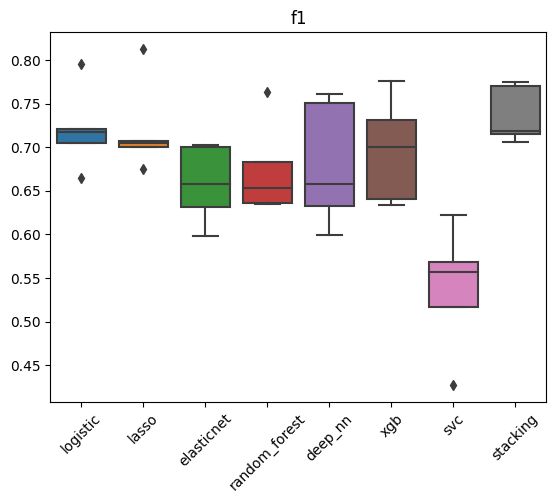

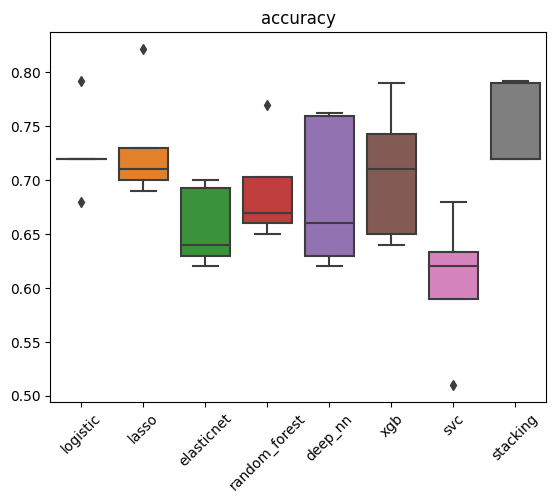

In [45]:
plot_scores(estimator_lists, scorer_lists['cnv'])

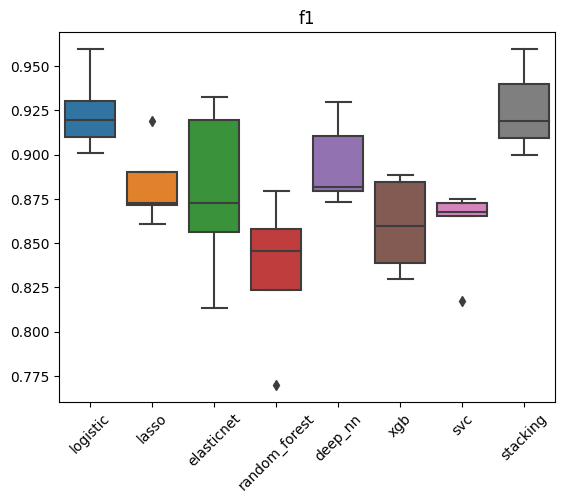

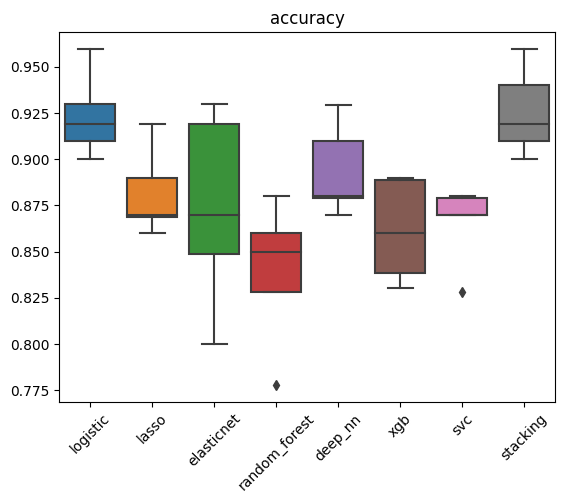

In [46]:
plot_scores(estimator_lists, scorer_lists['mrna'])

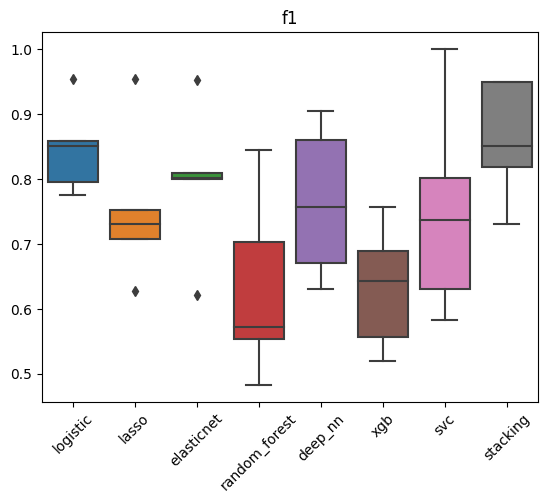

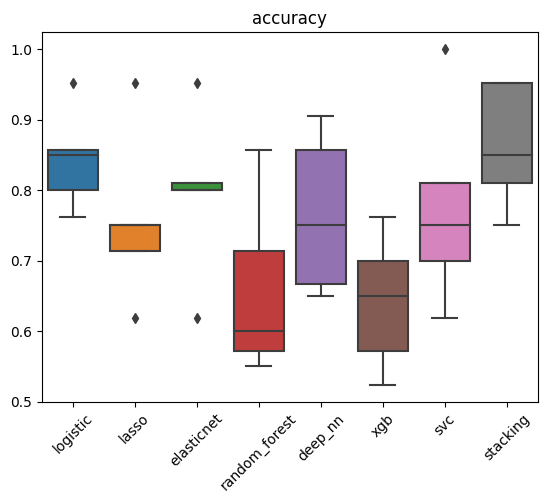

In [47]:
plot_scores(estimator_lists, scorer_lists['prot'])

# Feature Selection

In [8]:
new_data = {}

## cnv

In [77]:
import warnings
warnings.filterwarnings('ignore')

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['cnv'] if x == name)]

'''# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')
level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])

cv = KFold(n_splits = 3, random_state=1, shuffle=True)

model = StackingClassifier(estimator_list, final_estimator=level1, cv='prefit')'''

fs_cnv = FeatureSelection(estimator_list, 3)
fs_cnv.fit(data_reduced['cnv'], target['cnv'])

100%|██████████| 7991/7991 [58:39<00:00,  2.27it/s]  


In [81]:
# Finding the 100 most important features
indices = fs_cnv.best_n_features(100)
columns = data_reduced['cnv'].columns[indices]
print(columns)

Index(['XRCC4', 'RASEF', 'SGCA', 'FRMD3', 'COX11', 'NUAK1', 'ADAP2', 'ATP6V0C',
       'KCNJ16', 'LGALS9', 'SGSM2', 'LGR5', 'TPBG', 'CAMTA2', 'PHOSPHO1',
       'NPEPPS', 'AVPR1B', 'ZDHHC21', 'EME1', 'PPP1R9B', 'ANKRD40', 'MTRNR2L4',
       'MTRNR2L3', 'UQCRFS1', 'TMEM132C', 'TMEM92', 'UBQLN1', 'SPO11',
       'ANKFY1', 'AHSP', 'TCP11L2', 'KLHL4', 'GCNT2', 'GPR27', 'CACNG1',
       'SPAG9', 'RNF135', 'CNTROB', 'KPNB1', 'RAE1', 'STAU1', 'WFIKKN2',
       'TMEM88', 'KIF2B', 'GSG1L', 'IDNK', 'IKZF3', 'PTPRQ', 'RBM38', 'NEURL4',
       'TRAPPC1', 'CCDC85A', 'GKAP1', 'KRT24', 'HSPA14', 'GLT1D1', 'TPSG1',
       'ZNF652', 'RAD9B', 'ITGAD', 'KIF1C', 'CYB5D1', 'TGIF1', 'SLC15A4',
       'INCA1', 'PAH', 'ABCC3', 'TOM1L1', 'NLGN4X', 'COL1A1', 'TGIF2LX',
       'CCT2', 'C11orf54', 'RASSF9', 'LYZ', 'CEP112', 'FRS2', 'YEATS4',
       'CORO1C', 'SNX22', 'SAXO1', 'RNPEP', 'NAGS', 'FAM134C', 'RPS6', 'RLN2',
       'RPS2', 'RLF', 'DAPK2', 'RIT1', 'THNSL1', 'EPHX3', 'RPL19', 'ROCK1',
       'CFAP69', 'R

In [79]:
','.join(columns)

'XRCC4,RASEF,SGCA,FRMD3,COX11,NUAK1,ADAP2,ATP6V0C,KCNJ16,LGALS9,SGSM2,LGR5,TPBG,CAMTA2,PHOSPHO1,NPEPPS,AVPR1B,ZDHHC21,EME1,PPP1R9B,ANKRD40,MTRNR2L4,MTRNR2L3,UQCRFS1,TMEM132C,TMEM92,UBQLN1,SPO11,ANKFY1,AHSP,TCP11L2,KLHL4,GCNT2,GPR27,CACNG1,SPAG9,RNF135,CNTROB,KPNB1,RAE1,STAU1,WFIKKN2,TMEM88,KIF2B,GSG1L,IDNK,IKZF3,PTPRQ,RBM38,NEURL4,TRAPPC1,CCDC85A,GKAP1,KRT24,HSPA14,GLT1D1,TPSG1,ZNF652,RAD9B,ITGAD,KIF1C,CYB5D1,TGIF1,SLC15A4,INCA1,PAH,ABCC3,TOM1L1,NLGN4X,COL1A1,TGIF2LX,CCT2,C11orf54,RASSF9,LYZ,CEP112,FRS2,YEATS4,CORO1C,SNX22,SAXO1,RNPEP,NAGS,FAM134C,RPS6,RLN2,RPS2,RLF,DAPK2,RIT1,THNSL1,EPHX3,RPL19,ROCK1,CFAP69,RPAP2,PPTC7,EML5,RPL5,RPS8'

In [78]:
# Get scores of all subsets of features
fs_cnv.get_scores(data_reduced['cnv'], target['cnv'], 1000)

100%|██████████| 1000/1000 [01:26<00:00, 11.51it/s]


array([0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508982,
       0.45508982, 0.45508982, 0.45508982, 0.45508982, 0.45508

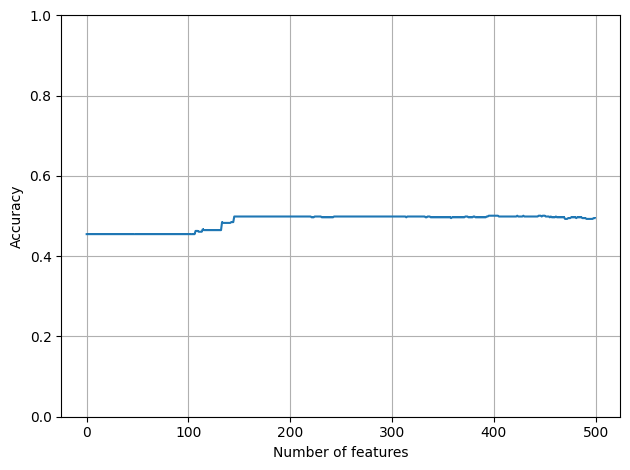

In [74]:
fs_cnv.plot_scores(500)

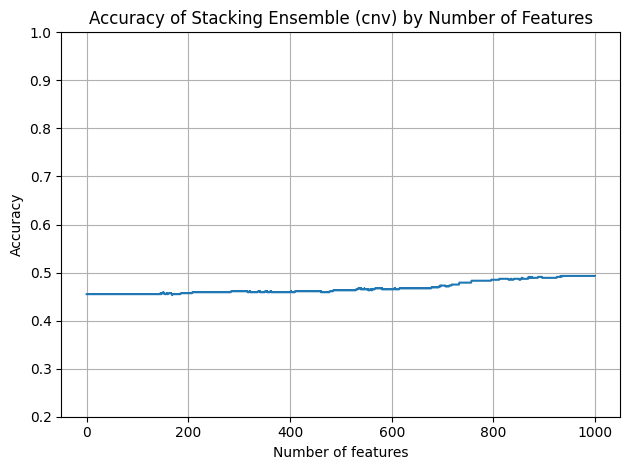

In [79]:
x = list(range(1000))
plt.plot(x, fs_cnv.scores_, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [82]:
scores = get_score_range(fs_cnv, estimator_list, data_reduced['cnv'], target['cnv'], 0, 7991)

100%|██████████| 7991/7991 [27:58<00:00,  4.76it/s]


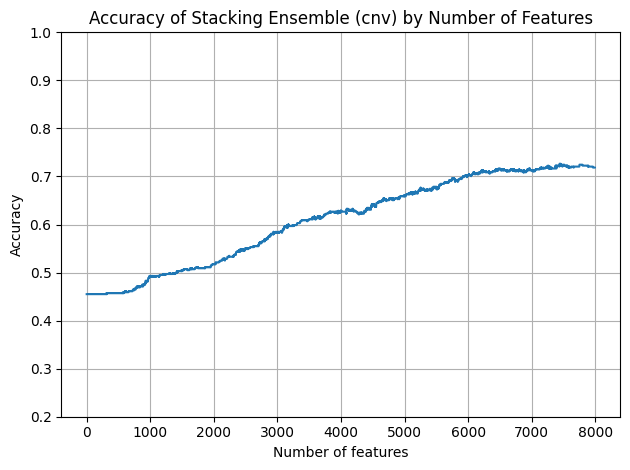

In [83]:
x = list(range(0, 7991))
plt.plot(x, scores, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [84]:
n_features = np.argmax(scores)
print(n_features)

7438


In [89]:
features = [1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7500, 8000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['cnv'] if x == name)]

for n in tqdm(features):
    
    indices = fs_cnv.best_n_features(n)
    columns = data_reduced['cnv'].columns[indices]

    new_data['cnv'] = data_reduced['cnv'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['cnv'], target['cnv'], metrics={'f1':make_scorer(f1_score, average='weighted'),
             'accuracy':'accuracy'}, cv=5)

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

100%|██████████| 14/14 [41:10<00:00, 176.49s/it]


,model,f1_score,accuracy
0,1000,0.726 +/- 0.039,0.736 +/- 0.039
1,1500,0.697 +/- 0.048,0.714 +/- 0.053
2,2000,0.730 +/- 0.038,0.742 +/- 0.039
3,2500,0.722 +/- 0.045,0.732 +/- 0.048
4,3000,0.731 +/- 0.047,0.740 +/- 0.051
5,3500,0.728 +/- 0.039,0.738 +/- 0.045
6,4000,0.748 +/- 0.027,0.758 +/- 0.031
7,4500,0.735 +/- 0.030,0.746 +/- 0.033
8,5000,0.725 +/- 0.029,0.736 +/- 0.034
9,5500,0.725 +/- 0.039,0.736 +/- 0.041


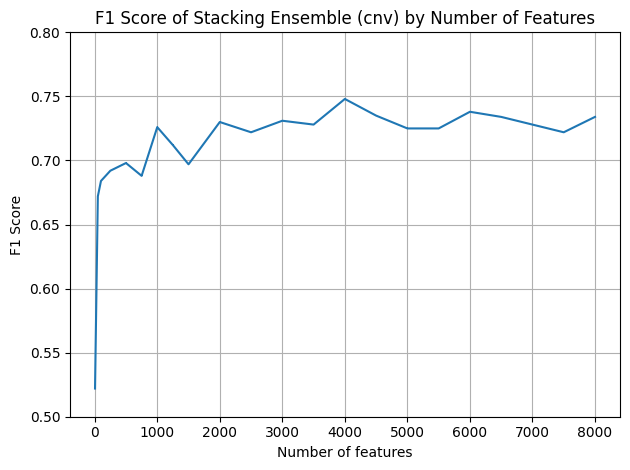

In [54]:
x = [5, 50, 100, 250, 500, 750, 1000, 1250, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7500, 8000]
y = [0.522, 0.672, 0.684, 0.692, 0.698, 0.688, 0.726, 0.712, 0.697, 0.730, 0.722, 0.731, 0.728, 0.748, 0.735, 0.725, 0.725, 0.738, 0.734, 0.722, 0.734]
plt.plot(x, y, marker=',')
plt.ylim([0.5, 0.8])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Stacking Ensemble (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

Top scoring number of features is 4000.

In [39]:
cnv = pd.read_pickle("cnv_reduced.pkl")

In [56]:
# Finding the n most important features based on plot
#indices = fs_cnv.best_n_features(4000)
#columns = data_reduced['cnv'].columns[indices]

#new_data['cnv'] = data_reduced['cnv'].loc[:, columns]

col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['cnv'] if x == name)]

# Perform 5-fold cross-validation
model, scores = trainStackingModel(estimator_list, LogisticRegression(), cnv.iloc[:, : 4000], target['cnv'], metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}, cv=5)

metrics = pd.concat([metrics, pd.DataFrame([['cnv', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

/opt/tljh/user/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
/opt/tljh/user/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


KeyboardInterrupt: 

In [93]:
new_data['cnv'].to_pickle("cnv_reduced.pkl")

## mRNA

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Selecting mRNA estimators
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]

fs_rna = EnsembleFeatureSelection(estimator_list, 3)
fs_rna.fit(data_reduced['mrna'], target['mrna'])

  2%|▏         | 120/6428 [01:37<1:25:22,  1.23it/s]


KeyboardInterrupt: 

In [39]:
# Finding the 100 most important features
indices = fs_rna.best_n_features(100)
columns = data_reduced['mrna'].columns[indices]

print(','.join(columns))
print(fs.avg_importances[indices])

Index(['TRIM29', 'CEP55', 'PRAME', 'PKHD1', 'IRS1', 'IL17B', 'IGHV3-20',
       'IGLV1-40', 'STC2', 'BPIFB1', 'OTOGL', 'MALRD1', 'STARD3', 'GTSE1',
       'SCGB1D2', 'SHC4', 'DSG1', 'NOX5', 'PLCXD3', 'ERO1B', 'TDRD1', 'KLHL31',
       'CACNG4', 'CACNG1', 'SOSTDC1', 'SCGB2A2', 'KRT81', 'C2orf50', 'SLC39A6',
       'PNMT', 'TMEM26', 'KCTD19', 'KCNJ3', 'SYT8', 'RASSF6', 'DSG3', 'IQGAP3',
       'DSC3', 'ARHGEF38', 'SCGB2A1', 'HCN4', 'PSD2', 'AMN1', 'ERC2', 'GINS1',
       'LINC00162', 'ALG1L', 'TOB1', 'SDC1', 'DYDC2', 'MIEN1', 'KRT14', 'PRPH',
       'PTPN20', 'TUSC8', 'CPNE4', 'LRP1B', 'BCO1', 'RPS21', 'PWP2', 'ESR1',
       'TRIM55', 'USP32P1', 'LRRC26', 'TDRD5', 'CITED4', 'FAM83D', 'WFDC2',
       'PCDHGA8', 'SPNS3', 'RDM1', 'CDKN3', 'GABRQ', 'LOC101927755', 'PART1',
       'LPPR3', 'CNTNAP3', 'SYNPO2L', 'TCN1', 'NXF3', 'TGM3', 'PDZD3', 'CD1C',
       'STAC2', 'PLA2G4E-AS1', 'RERGL', 'CAPN6', 'TGFA', 'RIMS2', 'CENPF',
       'SLC16A9', 'SOX9-AS1', 'CPB1', 'LRRC59', 'MCM10', 'COL17A1', 

In [40]:
# Getting scores for 4000 feature subsets
fs_rna.get_scores(data_reduced['mrna'], target['mrna'], 4000)

100%|██████████| 4000/4000 [04:35<00:00, 14.53it/s]


array([0.29317269, 0.29317269, 0.25903614, ..., 0.39959839, 0.39959839,
       0.39959839])

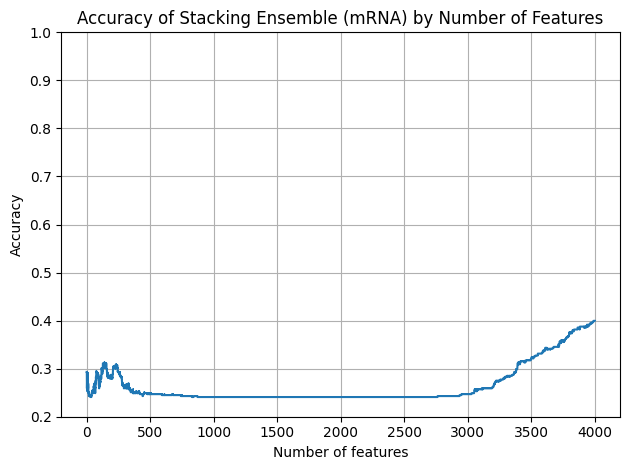

In [43]:
x = list(range(0, 4000))
plt.plot(x, fs_rna.scores_, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (mRNA) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [58]:
def get_score_range(fs, estimators, data, target, start, end):
        scores_ = []

        cv = KFold(n_splits=fs.cv, random_state=1, shuffle=True)
        for train_index, test_index in cv.split(data):
            
            X, X_test = data.iloc[train_index, :], data.iloc[test_index, :]
            y, y_test = target.iloc[train_index], target.iloc[test_index]
            
            # Fitting base estimators 
            for name, estimator in estimators:
                estimator.fit(X, y)
            
            # Create the transformer to impute missing values
            imputer = SimpleImputer(strategy='mean')
            level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])
            
            # Fitting stacking model
            fs.model = StackingClassifier(estimators, final_estimator=level1, cv='prefit')
            fs.model.fit(X, y)
            
            scores = []

            for i in tqdm(range(start, end)):
                indices = fs.best_n_features(i)
                temp = X_test.copy()
                all_cols = temp.columns
                selected_cols = np.delete(np.arange(len(all_cols)), indices)
                temp.iloc[:, selected_cols] = 0
                y_pred = fs.model.predict(temp)
                score = accuracy_score(y_test, y_pred)
                scores.append(score)
        
            scores_.append(scores)
        
        scores_ = np.average(scores_, axis=0)
        
        return scores_

In [62]:
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]

scores = get_score_range(fs_rna, estimator_list, data_reduced['mrna'], target['mrna'], 0, 6000)

100%|██████████| 6000/6000 [04:12<00:00, 23.74it/s]


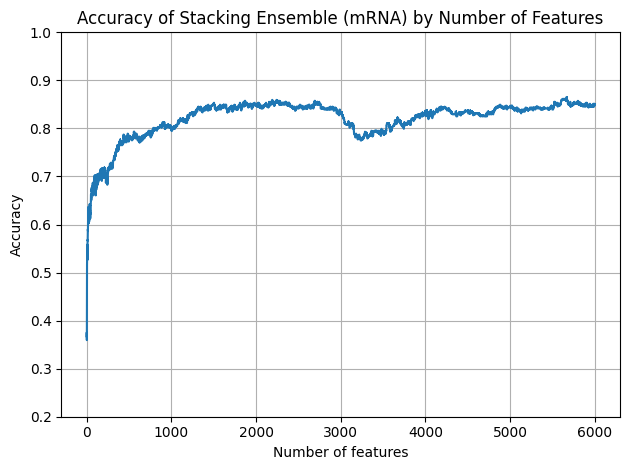

In [64]:
x = list(range(0, 6000))
plt.plot(x, scores, marker=',')
plt.ylim([0.2, 1])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (mRNA) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [65]:
n_features = np.argmax(scores)
print(n_features)

5668


In [96]:
features = [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]
score_list = []

for n in tqdm(features):
    
    indices = fs_rna.best_n_features(n)
    columns = data_reduced['mrna'].columns[indices]

    new_data['mrna'] = data_reduced['mrna'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['mrna'], target['mrna'], metrics={'f1':make_scorer(f1_score, average='weighted'),
             'accuracy':'accuracy'}, cv=5)
    
    score_list.append(scores)

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

100%|██████████| 13/13 [05:53<00:00, 27.23s/it]


,model,f1_score,accuracy
0,500,0.909 +/- 0.034,0.908 +/- 0.035
1,1000,0.916 +/- 0.033,0.916 +/- 0.033
2,1500,0.922 +/- 0.020,0.922 +/- 0.021
3,2000,0.913 +/- 0.024,0.914 +/- 0.023
4,2500,0.916 +/- 0.021,0.916 +/- 0.022
5,3000,0.916 +/- 0.020,0.916 +/- 0.019
6,3500,0.920 +/- 0.020,0.920 +/- 0.020
7,4000,0.912 +/- 0.019,0.912 +/- 0.019
8,4500,0.918 +/- 0.018,0.918 +/- 0.018
9,5000,0.916 +/- 0.014,0.916 +/- 0.015


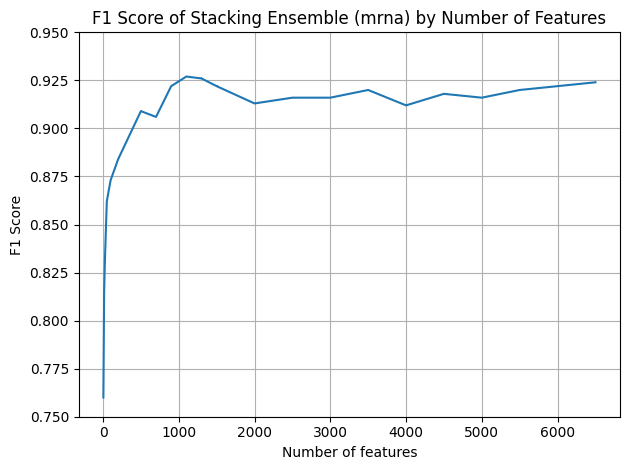

In [38]:
x = [5, 15, 25, 50, 100, 200, 500, 700, 900, 1100, 1300, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
y = [0.760, 0.815, 0.831, 0.862, 0.873, 0.884, 0.909, 0.906, 0.922, 0.927, 0.926, 0.922, 0.913, 0.916, 0.916, 0.920, 0.912, 0.918, 0.916, 0.920, 0.922, 0.924]
plt.plot(x, y, marker=',')
plt.ylim([0.75, 0.95])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Stacking Ensemble (mrna) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [60]:
mrna = pd.read_pickle("mrna_reduced.pkl")

In [57]:

# Finding the n most important features (based on maximum)
#indices = fs_rna.best_n_features(1300)
#columns = data_reduced['mrna'].columns[indices]

#new_data['mrna'] = data_reduced['mrna'].loc[:, columns]

col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['mrna'] if x == name)]

model, scores = trainStackingModel(estimator_list, LogisticRegression(), mrna.iloc[:, : 1100], target['mrna'], metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}, cv=5)

metrics = pd.concat([metrics, pd.DataFrame([['mrna', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

,model,f1_score,accuracy
0,mrna,0.927 +/- 0.028,0.926 +/- 0.028


In [105]:
new_data['mrna'].to_pickle("mrna_reduced.pkl")

## Prot:

In [21]:
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['prot'] if x == name)]

fs = EnsembleFeatureSelection(estimator_list, 3)
fs.fit(data_reduced['prot'], target['prot'])

100%|██████████| 3121/3121 [10:31<00:00,  4.94it/s]


In [30]:
# Finding the 100 most important features
indices = fs.best_n_features(100)
columns = data_reduced['prot'].columns[indices]

# Converting to a string for enrichment analysis
print(','.join(columns))
print(fs.avg_importances[indices])

KRT7,PGLYRP1,MYL12B,PM20D2,CLC,TIPIN,OGFOD3,UCHL1,LALBA,APPBP2,DCAF10,FBXO9,DBI,PYDC1,KRT81,FCN3,UBE2J1,TMCO6,SOX9,UBA52,UAP1,LCN2,CLSTN1,DEFA3,OTUD5,PAPSS2,TELO2,CARTPT,WDR41,FAM129A,SCGN,HSD17B7,GRB14,RARRES1,ICAM3,PADI4,LMX1B,MTL5,HSPA4L,TG,CHMP3,MUC16,VCAN,SEC14L1,MUCL1,VTCN1,FAM111B,CLSTN2,IGSF1,C10orf54,KIAA1147,TMX4,ATP1B1,TRUB2,PSAT1,PRTN3,TNFAIP2,NT5C2,IRF7,SMOC1,COLEC12,CRABP1,PROM1,PRNP,AZU1,KBTBD2,NPNT,SLC34A2,PRG2,PRPF40B,KRT23,TSPAN6,GLDC,NUSAP1,KRT16,CXCL12,TVP23C,NCCRP1,PTX3,TMEM165,POR,IMPA2,TSPYL5,TMEM189-UBE2V1,INHBA,TMEM230,INO80C,INPP4B,CTHRC1,SNX24,SHPK,GLRX,SIAH1,CNNM3,DNAL1,CALML5,RETN,S100A1,HMGN3,EGFR
[0.01932773 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392 0.00980392
 0.00980392 0.00980392 0.00980

100%|██████████| 2000/2000 [06:33<00:00,  5.09it/s]


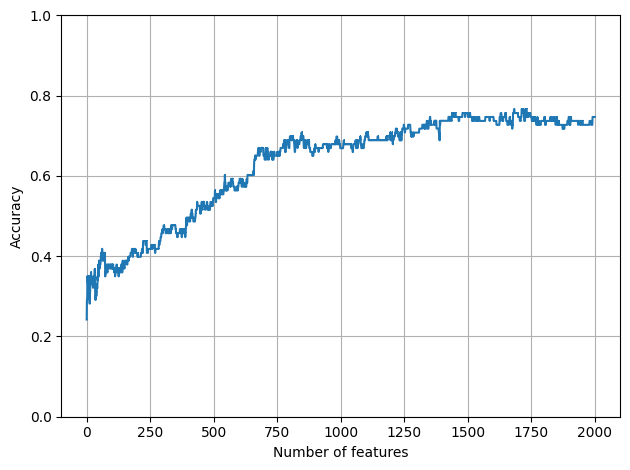

In [26]:
# Getting scores for each feature subset and plotting scores
fs.get_scores(data_reduced['prot'], target['prot'], 2000)

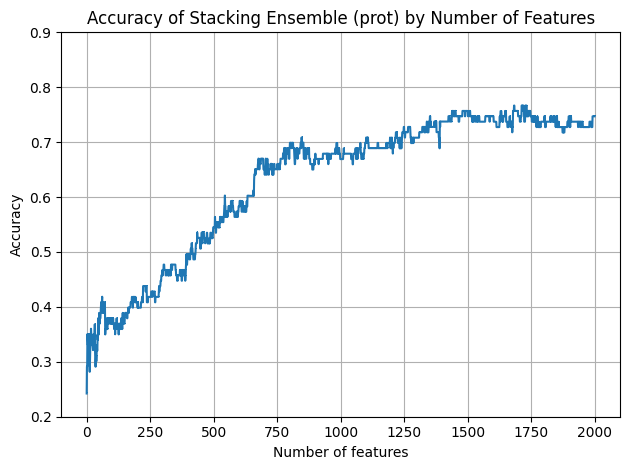

In [28]:
x = list(range(0, 2000))
plt.plot(x, fs.scores_, marker=',')
plt.ylim([0.2, 0.9])
plt.ylabel('Accuracy')
plt.xlabel('Number of features')
plt.title('Accuracy of Stacking Ensemble (prot) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

In [46]:
n_features = fs.scores_.argmax()
print(n_features)

1682


We see that performance plateaus at around 1700 features.

In [25]:
features = [5, 10, 15, 20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['prot'] if x == name)]
score_list = []

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['prot'].columns[indices]

    new_data['prot'] = data_reduced['prot'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['prot'], target['prot'], metrics={'f1':make_scorer(f1_score, average='weighted'),
             'accuracy':'accuracy'}, cv=5)

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

 94%|█████████▍| 32/34 [00:40<00:04,  2.14s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_base.py:440: RuntimeWarning: invalid value encountered in true_divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))
100%|██████████| 34/34 [00:45<00:00,  1.32s/it]


,model,f1_score,accuracy
0,5,0.336 +/- 0.089,0.369 +/- 0.078
1,10,0.372 +/- 0.028,0.428 +/- 0.025
2,15,0.396 +/- 0.050,0.437 +/- 0.032
3,20,0.416 +/- 0.041,0.466 +/- 0.025
4,100,0.582 +/- 0.105,0.582 +/- 0.108
5,200,0.679 +/- 0.115,0.680 +/- 0.114
6,300,0.741 +/- 0.130,0.747 +/- 0.123
7,400,0.758 +/- 0.134,0.767 +/- 0.126
8,500,0.799 +/- 0.102,0.805 +/- 0.097
9,600,0.798 +/- 0.101,0.805 +/- 0.097


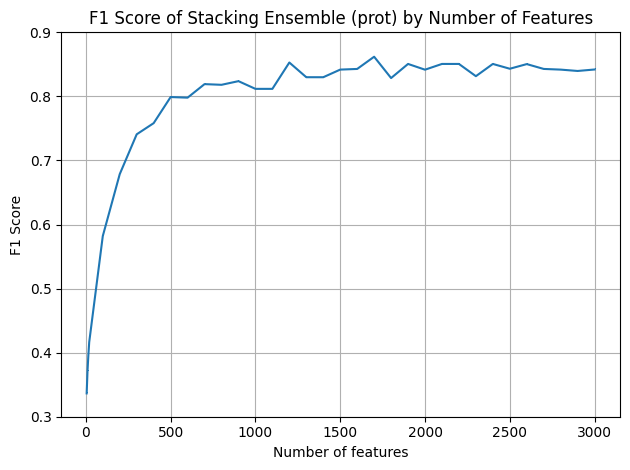

In [29]:
x = [500, 625, 750, 875, 1000, 1125, 1250, 1375, 1500, 1625, 1700, 1750, 2000, 2250, 2500, 2750, 3000]
y = [0.799, 0.808, 0.819, 0.842, 0.812, 0.821, 0.824, 0.851, 0.842, 0.852, 0.862, 0.820, 0.842, 0.851, 0.843, 0.843, 0.842]
plt.plot(features, score_list, marker=',')
plt.ylim([0.30, 0.9])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Stacking Ensemble (prot) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

The score is highest at 1700 features.

In [111]:
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

# Finding the 1700 most important features
indices = fs.best_n_features(1700)
columns = data_reduced['prot'].columns[indices]

new_data['prot'] = data_reduced['prot'].loc[:, columns]

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators['prot'] if x == name)]

# Performing 10-fold cross-validation to get update metric
model, scores = trainStackingModel(estimator_list, LogisticRegression(), new_data['prot'], target['prot'], metrics={'f1':make_scorer(f1_score, average='weighted'),
         'accuracy':'accuracy'}, cv=5)

metrics = pd.concat([metrics, pd.DataFrame([['prot', '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)

metrics

,model,f1_score,accuracy
0,prot,0.862 +/- 0.102,0.863 +/- 0.100


In [112]:
new_data['prot'].to_pickle("prot_reduced.pkl")

## Total

In [114]:
col_names = ['model', 'f1', 'accuracy']
stacking_metrics = pd.DataFrame(columns=col_names)
stacking_model = {}
scores = {}

for modality in datasets:
    print("dataset: " + modality)
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators[modality] if x == name)]
    
    stacking_model[modality], scores[modality] = trainStackingModel(estimator_list, LogisticRegression(), new_data[modality], target[modality], metrics=_metrics, cv=5)

    stacking_metrics = pd.concat([stacking_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores[modality]['test_f1']), np.std(scores[modality]['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores[modality]['test_accuracy']), np.std(scores[modality]['test_accuracy']))]], columns=col_names)], ignore_index=True)

dataset: cnv
dataset: mrna
dataset: prot


In [115]:
stacking_metrics

,model,f1,accuracy
0,cnv,0.748 +/- 0.027,0.758 +/- 0.031
1,mrna,0.926 +/- 0.030,0.926 +/- 0.030
2,prot,0.862 +/- 0.102,0.863 +/- 0.100


In [84]:
new_data['cnv'].to_csv('cnv_reduced.csv', index=False)
new_data['mrna'].to_csv('mrna_reduced.csv', index=False)
new_data['prot'].to_csv('prot_reduced.csv', index=False)

In [116]:
new_data['cnv'].to_pickle("cnv_reduced.pkl")
new_data['mrna'].to_pickle("mrna_reduced.pkl")
new_data['prot'].to_pickle("prot_reduced.pkl")

In [7]:
read_data = {}
read_data['cnv'] = pd.read_pickle("cnv_reduced.pkl")
read_data['mrna'] = pd.read_pickle("mrna_reduced.pkl")
read_data['prot'] = pd.read_pickle("prot_reduced.pkl")

## Base Learners

In [15]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)

fs = BaseFeatureSelection(model, 3)
fs.fit(data_reduced['cnv'], target['cnv'])

100%|██████████| 7991/7991 [03:35<00:00, 37.00it/s]


In [17]:
indices = fs.best_n_features(100)
columns = data_reduced['cnv'].columns[indices]
print(indices)
print(','.join(columns))
print(fs.avg_importances[indices])

[1569 7965 5958 2030 5020 2337 6517  355 6687 5638 5696  410 6816 7430
  714 2775 6202 2349 1516 7095 1829 2668 5601 1619 4062 3783  206 1438
 3127  586  205 7304 1688 5310 5324 5323 5311 5322 5316 5312 5314 5320
 5315 5319 5318 5317 5321 5313    0 5326 5353 5352 5351 5350 5348 5347
 5346 5345 5344 5343 5342 5341 5325 5340 5338 5337 5336 5335 5334 5333
 5332 5331 5309 5329 5328 5327 5339 5330 5301 5307 5276 5275 5274 5273
 5272 5271 5270 5269 5268 5267 5266 5265 5277 5264 5262 5261 5260 5259
 5258 5257]
PRKAA2,MIR6884,PGAP3,THRA,XYLT2,DGKE,EME1,COL1A1,TMEM92,MIEN1,PPP1R9B,CSF3,SAMD14,COA6,GAS6,MED24,ZPBP2,TCAP,PNMT,GSDMA,SGCA,NR1D1,PPP1R1B,PSMD3,MRPL27,DKK4,C8B,PDK2,STARD3,ERBB2,C8A,TMEM255B,RARRES2,TMC7,JADE1,CEP76,ACTR5,PAQR6,SPEF2,ATAD5,C2orf54,LPPR3,MRM1,ZNF696,SYNPO2L,MAP6D1,ERMP1,SETD6,A1BG,SCD5,MROH9,CCDC170,TRIM46,CCDC176,BICC1,C3orf36,ZNF606,ADAMTS20,TMEM62,C14orf159,FAM188A,PHC3,DNAJC22,FAM192A,TMEM156,C10orf88,TRAPPC13,ESRP2,GREB1L,ELOVL7,PLEKHH3,POF1B,NAA60,FRMD1,WLS,WDR76,

The top 33 have an individual impact on accuracy.

In [82]:
indices = fs.best_n_features(33)
columns = data_reduced['cnv'].columns[indices]
print(','.join(columns))

PRKAA2,MIR6884,PGAP3,THRA,XYLT2,DGKE,EME1,COL1A1,TMEM92,MIEN1,PPP1R9B,CSF3,SAMD14,COA6,GAS6,MED24,ZPBP2,TCAP,PNMT,GSDMA,SGCA,NR1D1,PPP1R1B,PSMD3,MRPL27,DKK4,C8B,PDK2,STARD3,ERBB2,C8A,TMEM255B,RARRES2


In [84]:
import warnings
from pandas.errors import SettingWithCopyWarning
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore')

features = [5, 20, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500, 7000, 7500, 8000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
score_list = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
new_base_data = {}

model = ('lr', LogisticRegression(solver='saga', multi_class='multinomial', random_state=1))
pipe=Pipeline(steps=[('data_prep',transformer),model])

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['cnv'].columns[indices]

    new_base_data['cnv'] = data_reduced['cnv'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    scores = cross_validate(model[1], new_base_data['cnv'], target['cnv'], scoring=_metrics, cv=cv, n_jobs = -1, error_score='raise')

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

  5%|▍         | 1/21 [00:00<00:13,  1.43it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 10%|▉         | 2/21 [00:01<00:09,  2.10it/s]/opt/tljh/user/lib

 48%|████▊     | 10/21 [00:08<00:14,  1.36s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 52%|█████▏    | 11/21 [00:10<00:15,  1.53s/it]/opt/tljh/user/l

 90%|█████████ | 19/21 [00:36<00:07,  3.61s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 95%|█████████▌| 20/21 [00:41<00:03,  3.89s/it]/opt/tljh/user/l

,model,f1_score,accuracy
0,5,0.452 +/- 0.042,0.539 +/- 0.037
1,20,0.508 +/- 0.043,0.555 +/- 0.030
2,50,0.616 +/- 0.074,0.639 +/- 0.065
3,100,0.673 +/- 0.053,0.689 +/- 0.050
4,200,0.708 +/- 0.040,0.720 +/- 0.042
5,500,0.737 +/- 0.029,0.744 +/- 0.029
6,1000,0.743 +/- 0.049,0.752 +/- 0.046
7,1500,0.735 +/- 0.057,0.744 +/- 0.054
8,2000,0.734 +/- 0.057,0.742 +/- 0.054
9,2500,0.733 +/- 0.054,0.742 +/- 0.051


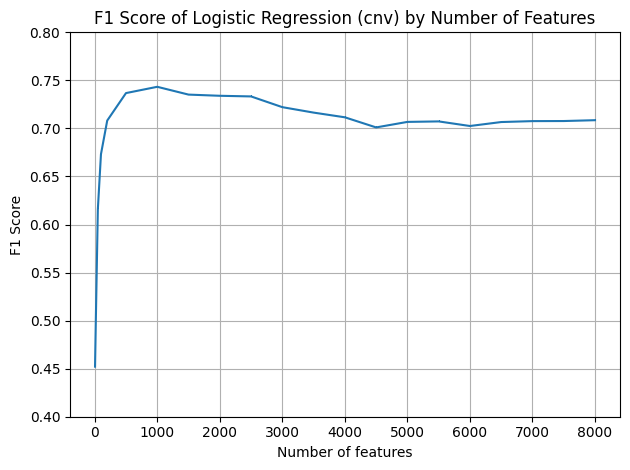

In [87]:
x = features
y = score_list
plt.plot(x, y, marker=',')
plt.ylim([0.4, 0.80])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Logistic Regression (cnv) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

### mRNA

In [67]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)
fs = BaseFeatureSelection(model, 3)
fs.fit(data_reduced['mrna'], target['mrna'])

indices = fs.best_n_features(100)
columns = data_reduced['mrna'].columns[indices]
print(indices)
print(','.join(columns))

100%|██████████| 6428/6428 [02:19<00:00, 46.22it/s]

[1035 4361 4162 4250 4738 5826  985  338 3834  991 4723 2884 3856 2870
 4698 2867 4688 5886 4715 5817 3810 2111 5687  909 3021 3016 3012  419
 5733 1511 5747 3757  383 4776 3792  370 2103 1558 4807 3885  293 2831
 1461 4576 2232 1456 6016 6023 3986 1463 1445 1101 4540  188 4513 1411
 1134 2664 2245 1464 5996  244 1500 1036 4655 4646  276 4645 2191 4641
 5939 5958 4613 1477  252 2780 5979 5980 3935 3037 2034 3050 3682 3470
 3473  744 5340 5343 5116 5112 5320 3291 1881  604 5371 3495 3496 3269
 1895 1878]
MYBPC1,SLC25A48,MYO3B,CBLN2,OTOGL,DDX3P1,MIP,HAPLN1,TDRD12,MMP1,PGBD3,ELOVL2,TMEM132C,DCHS2,MAP7D2,CFAP46,LINC01619,CEP164P1,PYDC1,RPS27P29,AOC4P,LEFTY1,SEC14L6,LCP1,SCN3B,PRR11,OGDHL,DRD2,MYHAS,TK1,RPL3P9,RGS8,DACH1,LOC284080,SYT8,CYP2B7P,DPYSL4,U2AF1,SMIM24,SDR42E1,CLCNKA,SNTG2,SYN2,CERS3,GPR182,SULT1A3,ASAP1-IT2,ALKBH3-AS1,LRG1,SYT1,SSTR1,OMG,FOXD4L1,CA12,PIANP,SLC15A2,SERPINA5,ST8SIA5,RHOBTB3,SYT5,LINC00327,CDH4,LEFTY2,MYBL2,PCGF7P,SPESP1,CHRM1,LINC00315,ADAMTS8,RSPH10B,LOC100505504

In [73]:
indices = fs.best_n_features(100)
print(fs.avg_importances[indices])

[0.00401606 0.00401606 0.00401606 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803
 0.00200803 0.00200803 0.00200803 0.00200803 0.00200803 0.0020

In [74]:
import warnings
warnings.filterwarnings('ignore')

features = [5, 20, 50, 100, 200, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000, 6500]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
score_list = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
new_base_data = {}

model = ('lr', LogisticRegression(solver='saga', multi_class='multinomial', random_state=1))
pipe=Pipeline(steps=[('data_prep',transformer),model])

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['mrna'].columns[indices]

    new_base_data['mrna'] = data_reduced['mrna'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    scores = cross_validate(model[1], new_base_data['mrna'], target['mrna'], scoring=_metrics, cv=cv, n_jobs = -1, error_score='raise')

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

  0%|          | 0/18 [00:00<?, ?it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 1/18 [00:00<00:11,  1.54it/s]/opt/tljh/user/lib/python3

 50%|█████     | 9/18 [00:06<00:10,  1.11s/it]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 56%|█████▌    | 10/18 [00:08<00:10,  1.35s/it]/opt/tljh/user/li

100%|██████████| 18/18 [00:32<00:00,  1.79s/it]


,model,f1_score,accuracy
0,5,0.517 +/- 0.033,0.550 +/- 0.025
1,20,0.665 +/- 0.018,0.669 +/- 0.027
2,50,0.704 +/- 0.025,0.707 +/- 0.027
3,100,0.777 +/- 0.034,0.777 +/- 0.033
4,200,0.765 +/- 0.040,0.763 +/- 0.039
5,500,0.837 +/- 0.026,0.837 +/- 0.025
6,1000,0.859 +/- 0.032,0.860 +/- 0.031
7,1500,0.858 +/- 0.029,0.858 +/- 0.029
8,2000,0.855 +/- 0.033,0.856 +/- 0.032
9,2500,0.863 +/- 0.027,0.864 +/- 0.025


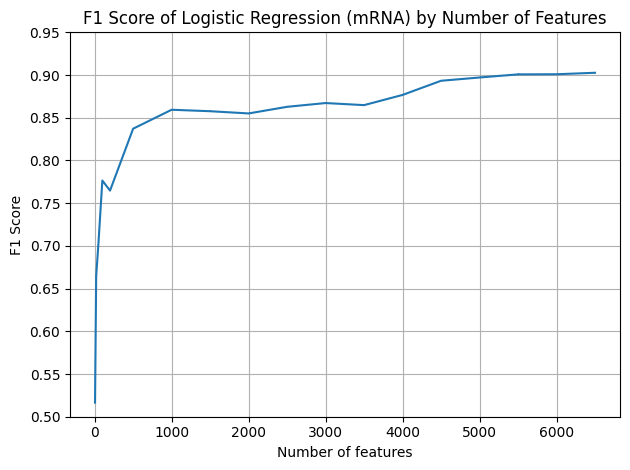

In [79]:
x = features
y = score_list
plt.plot(x, y, marker=',')
plt.ylim([0.5, 0.95])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Logistic Regression (mRNA) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

### prot

In [10]:
import warnings
warnings.filterwarnings('ignore')

model = LogisticRegression(solver='saga', multi_class='multinomial', random_state=1)
fs = BaseFeatureSelection(model, 3)
fs.fit(data_reduced['prot'], target['prot'])

100%|██████████| 3121/3121 [00:32<00:00, 95.99it/s]


In [45]:
indices = fs.best_n_features(100)
columns = data_reduced['prot'].columns[indices]
print(indices)
print(','.join(columns))

[2366 2194 2919 1565 2076 1996  863 2853 2643  548 2075 2077 2078 2079
 2080 2081    0 2084 2085 2086 2087 2088 2089 2090 2091 2082 2083 2072
 2073 2052 2053 2054 2055 2056 2057 2058 2059 2060 2061 2062 2063 2064
 2065 2066 2067 2068 2069 2070 2071 2092 2074 2093 2096 2095 2120 2121
 2122 2123 2124 2125 2126 2127 2128 2119 2129 2131 2132 2133 2134 2135
 2136 2137 2138 2139 2130 2094 2118 2116 2051 2097 2098 2099 2100 2101
 2102 2103 2104 2117 2105 2107 2108 2109 2110 2111 2112 2113 2114 2115
 2106 2050]
S100A1,PYDC1,TUBB2B,MAPT,POF1B,PGR,ERBB2,TPRG1,STC2,CLEC3A,PODXL,POLA2,POLB,POLDIP2,POLE,POLE4,A2M,POLR3GL,POMP,POP4,POR,POSTN,POT1,POTEF,PPA1,POLG2,POLI,PNPO,POC1B,PLG,PLIN1,PLIN2,PLIN4,PLIN5,PLK1,PLOD1,PLOD2,PLS1,PLTP,PLVAP,PLXDC2,PM20D2,PMP2,PMS1,PMVK,PNMT,PNP,PNPLA4,PNPLA8,PPA2,PODN,PPAPDC2,PPFIBP2,PPDPF,PRELP,PREP,PREX1,PRG2,PRKAA2,PRKAG2,PRKAR1B,PRKCA,PRKCB,PRCC,PRKCDBP,PRKD1,PRKRIP1,PRMT3,PRMT7,PRNP,PRODH,PROM1,PROS1,PROSC,PRKCH,PPBP,PRC1,PPT1,PLEKHS1,PPIAL4G,PPIB,PPIC,PPID,PPIH,

In [40]:
fs.avg_importances[indices]

array([0.00980392, 0.00980392, 0.00980392, 0.00980392, 0.00980392,
       0.00980392, 0.00980392, 0.00980392, 0.00980392, 0.00980392,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

Here we can see that only the first 10 features actually make a difference in the overall score when set to 0.

In [64]:
import warnings
warnings.filterwarnings('ignore')

features = [5, 10, 15, 20, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000]
col_names = ['model', 'f1_score', 'accuracy']
metrics = pd.DataFrame(columns=col_names)
score_list = []
cv = KFold(n_splits=5, random_state=1, shuffle=True)
new_base_data = {}

model = ('lr', LogisticRegression(solver='saga', multi_class='multinomial', random_state=1))
pipe=Pipeline(steps=[('data_prep',transformer),model])

for n in tqdm(features):
    
    indices = fs.best_n_features(n)
    columns = data_reduced['prot'].columns[indices]

    new_base_data['prot'] = data_reduced['prot'].loc[:, columns]
    
    # Perform 5-fold cross-validation
    scores = cross_validate(model[1], new_base_data['prot'], target['prot'], scoring=_metrics, cv=cv, n_jobs = -1, error_score='raise')

    metrics = pd.concat([metrics, pd.DataFrame([[n, '%.3f +/- %.3f' %(np.mean(scores['test_f1']), np.std(scores['test_f1'])), '%.3f +/- %.3f' %(np.mean(scores['test_accuracy']), np.std(scores['test_accuracy']))]], columns=col_names)], ignore_index=True)
    score_list.append(np.mean(scores['test_f1']))
    
metrics

  3%|▎         | 1/34 [00:00<00:22,  1.45it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
  6%|▌         | 2/34 [00:00<00:14,  2.14it/s]/opt/tljh/user/lib

 29%|██▉       | 10/34 [00:03<00:08,  2.81it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 32%|███▏      | 11/34 [00:03<00:06,  3.60it/s]/opt/tljh/user/l

 56%|█████▌    | 19/34 [00:05<00:03,  3.78it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 59%|█████▉    | 20/34 [00:05<00:03,  3.50it/s]/opt/tljh/user/l

 82%|████████▏ | 28/34 [00:08<00:02,  2.49it/s]/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/tljh/user/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
 85%|████████▌ | 29/34 [00:09<00:02,  2.42it/s]/opt/tljh/user/l

,model,f1_score,accuracy
0,5,0.526 +/- 0.133,0.527 +/- 0.128
1,10,0.516 +/- 0.093,0.514 +/- 0.088
2,15,0.577 +/- 0.110,0.572 +/- 0.113
3,20,0.585 +/- 0.058,0.582 +/- 0.054
4,100,0.617 +/- 0.062,0.612 +/- 0.056
5,200,0.706 +/- 0.083,0.710 +/- 0.083
6,300,0.725 +/- 0.104,0.727 +/- 0.101
7,400,0.771 +/- 0.094,0.776 +/- 0.091
8,500,0.762 +/- 0.081,0.767 +/- 0.077
9,600,0.772 +/- 0.043,0.776 +/- 0.041


In [65]:
metrics

,model,f1_score,accuracy
0,5,0.526 +/- 0.133,0.527 +/- 0.128
1,10,0.516 +/- 0.093,0.514 +/- 0.088
2,15,0.577 +/- 0.110,0.572 +/- 0.113
3,20,0.585 +/- 0.058,0.582 +/- 0.054
4,100,0.617 +/- 0.062,0.612 +/- 0.056
5,200,0.706 +/- 0.083,0.710 +/- 0.083
6,300,0.725 +/- 0.104,0.727 +/- 0.101
7,400,0.771 +/- 0.094,0.776 +/- 0.091
8,500,0.762 +/- 0.081,0.767 +/- 0.077
9,600,0.772 +/- 0.043,0.776 +/- 0.041


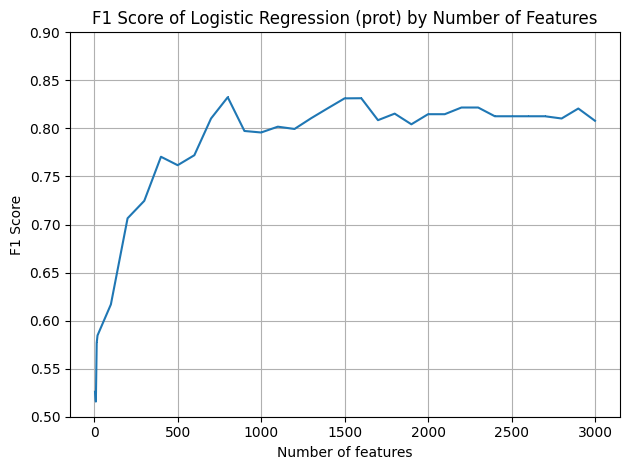

In [66]:
x = features
y = score_list
plt.plot(x, y, marker=',')
plt.ylim([0.5, 0.9])
plt.ylabel('F1 Score')
plt.xlabel('Number of features')
plt.title('F1 Score of Logistic Regression (prot) by Number of Features')
plt.grid()
plt.tight_layout()
plt.show()

# Sequential Feature Selection

In [16]:
class SequentialForwardSelection():
     
    '''
    Instantiate with Estimator and given number of features
    '''
    def __init__(self, k_features):
        self.k_features = k_features
         
    '''
    X_train - Training data Pandas dataframe
    X_test - Test data Pandas dataframe
    y_train - Training label Pandas dataframe
    y_test - Test data Pandas dataframe
    '''  
    def fit(self, X_train, X_test, y_train, y_test):
        print('hello')
        max_indices = tuple(range(X_train.shape[1]))
        total_features_count = len(max_indices)
        self.subsets_ = []
        self.scores_ = []
        self.indices_ = []
        '''
        Iterate through the feature space to find the first feature
        which gives the maximum model performance
        '''
        scores = []
        subsets = []
        
        lr = LogisticRegression(solver='saga', multi_class='multinomial')
        rf = RandomForestClassifier(n_estimators=100, random_state=0)
        deep = MLPClassifier(max_iter=500, random_state=0)
        
        lr = ('logistic',LogisticRegression(solver='saga', multi_class='multinomial'))
        rf = ('random_forest',RandomForestClassifier(n_estimators=100, random_state=0))
        deep = ('deep_nn',MLPClassifier(max_iter=500, random_state=0))
        
        lr[1].fit(X_train, y_train)
        rf[1].fit(X_train, y_train)
        deep[1].fit(X_train, y_train)
        
        self.estimator = StackingClassifier([lr, rf, deep], final_estimator=level1, cv='prefit')
        
        self.estimator.fit(X_train, y_train)
        
        for p in tqdm(list(combinations(max_indices, r=1))):
                score = self._calc_score(X_test, y_test.values, p)
                scores.append(score)
                subsets.append(p)

        #
        # Find the single feature having best score
        #
        best_score_index = np.argmax(scores)
        self.scores_.append(scores[best_score_index])
        self.indices_ = list(subsets[best_score_index])
        self.subsets_.append(self.indices_)
         
        #
        # Add a feature one by one until k_features is reached
        #
        dim = 1
        while dim < self.k_features:
            scores = []
            subsets = []
            current_feature = dim
            '''
            Add the remaining features one-by-one from the remaining feature set
            Calculate the score for every feature combinations
            '''
            idx = 0
            while idx < total_features_count:
                if idx not in self.indices_:
                    indices = list(self.indices_)
                    indices.append(idx)
                    score = self._calc_score(X_test, y_test.values, indices)
                    scores.append(score)
                    subsets.append(indices)
                idx += 1
             
            #
            # Get the index of best score
            #
            best_score_index = np.argmax(scores)
            #
            # Record the best score
            #
            self.scores_.append(scores[best_score_index])
            #
            # Get the indices of features which gave best score
            #
            self.indices_ = list(subsets[best_score_index])
            #
            # Record the indices of features for best score
            #
            self.subsets_.append(self.indices_)
             
            dim += 1
             
        self.k_score_ = self.scores_[-1]
     
    '''
    Transform training, test data set to the data set
    havng features which gave best score
    '''
    def transform(self, X):
        return X.values[:, self.indices_]
     
    '''
    Train models with specific set of features
    indices - indices of features
    '''
    def _calc_score(self, X_test, y_test, indices):
        temp = X_test.copy()
        temp[temp.columns.difference(indices, sort=False)] = 0
        y_pred = self.estimator.predict(temp)
        score = accuracy_score(y_test, y_pred)
        return score

In [17]:
prot_estimators = ['logistic', 'random_forest', 'deep_nn']

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in prot_estimators if x == name)]

# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')
level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])

data_reduced_train, data_reduced_test, target_train, target_test  = train_test_split(read_data['prot'], target['prot'], test_size=0.3, train_size=0.7)

fs = SequentialForwardSelection(5)

fs.fit(data_reduced_train, data_reduced_test, target_train, target_test)

hello


100%|██████████| 1250/1250 [03:26<00:00,  6.05it/s]


In [20]:
fs.scores_

[0.22580645161290322,
 0.22580645161290322,
 0.22580645161290322,
 0.22580645161290322,
 0.22580645161290322]

## Testing with KNN

### mRNA

In [40]:
data['mrna'].shape

(498, 17939)

In [39]:
knn = KNeighborsClassifier(n_neighbors=3)

In [52]:
sfs = sequential_forward_selection(knn, data['mrna'], target['mrna'], k_features = (10, 30), forward=True)

In [53]:
print('\nSequential Forward Selection, mRNA (k=20):')

pd.DataFrame.from_dict(sfs.get_metric_dict()).T


Sequential Forward Selection, mRNA (k=20):


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(1362,)","[0.6265060240963856, 0.6144578313253012, 0.554...",0.598394,"(FOXM1,)",0.071161,0.031623,0.02236
2,"(1362, 7393)","[0.7530120481927711, 0.7349397590361446, 0.746...",0.74498,"(FOXM1, SLC39A6)",0.016908,0.007513,0.005313
3,"(1355, 1362, 7393)","[0.8192771084337349, 0.8012048192771084, 0.783...",0.801205,"(FOXC1, FOXM1, SLC39A6)",0.033206,0.014756,0.010434
4,"(1355, 1362, 2549, 7393)","[0.8192771084337349, 0.8493975903614458, 0.825...",0.831325,"(FOXC1, FOXM1, MYO10, SLC39A6)",0.029285,0.013014,0.009202
5,"(1355, 1362, 2549, 4177, 7393)","[0.8433734939759037, 0.8493975903614458, 0.843...",0.845382,"(FOXC1, FOXM1, MYO10, HIRA, SLC39A6)",0.00639,0.00284,0.002008
6,"(1355, 1362, 2549, 4177, 5652, 7393)","[0.8433734939759037, 0.8554216867469879, 0.849...",0.849398,"(FOXC1, FOXM1, MYO10, HIRA, ZC3H11A, SLC39A6)",0.011069,0.004919,0.003478
7,"(1355, 1362, 2549, 4177, 4208, 5652, 7393)","[0.8313253012048193, 0.8614457831325302, 0.867...",0.853414,"(FOXC1, FOXM1, MYO10, HIRA, UBE2L3, ZC3H11A, S...",0.035581,0.015811,0.01118
8,"(1355, 1362, 2549, 4161, 4177, 4208, 5652, 7393)","[0.8433734939759037, 0.8674698795180723, 0.867...",0.859438,"(FOXC1, FOXM1, MYO10, TTC1, HIRA, UBE2L3, ZC3H...",0.025562,0.011359,0.008032
9,"(1355, 1362, 2549, 3360, 4161, 4177, 4208, 565...","[0.8493975903614458, 0.8614457831325302, 0.867...",0.859438,"(FOXC1, FOXM1, MYO10, RBBP5, TTC1, HIRA, UBE2L...",0.016908,0.007513,0.005313
10,"(1160, 1355, 1362, 2549, 3360, 4161, 4177, 420...","[0.8433734939759037, 0.8674698795180723, 0.873...",0.861446,"(ELAVL1, FOXC1, FOXM1, MYO10, RBBP5, TTC1, HIR...",0.029285,0.013014,0.009202


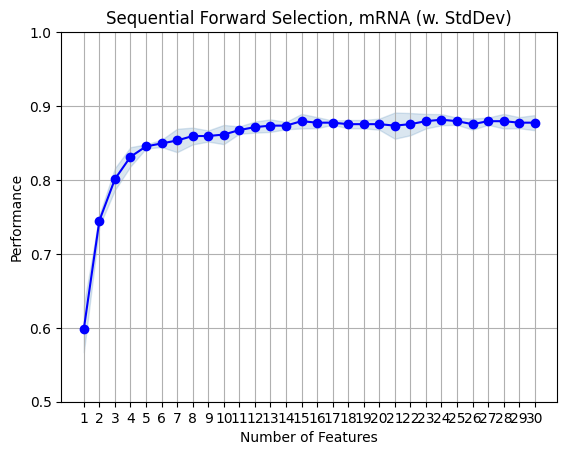

In [54]:
fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection, mRNA (w. StdDev)')
plt.grid()
plt.show()

In [63]:
print('top cv score: ' + str(sfs.k_score_))
print('feature indexes: ' + str(sfs.k_feature_idx_))
print('feature names: ' + str(sfs.k_feature_names_))

top cv score: 0.8815261044176707
feature indexes: (530, 1160, 1355, 1362, 2549, 2573, 2962, 3360, 3551, 4161, 4177, 4208, 4326, 4397, 4573, 4699, 5652, 6275, 7180, 7393, 7594, 8459, 9529, 11315)
feature names: ('KRIT1', 'ELAVL1', 'FOXC1', 'FOXM1', 'MYO10', 'NCK1', 'PKM', 'RBBP5', 'SAFB', 'TTC1', 'HIRA', 'UBE2L3', 'SF1', 'ZNF143', 'RBM10', 'RANBP3', 'ZC3H11A', 'EBP', 'TARDBP', 'SLC39A6', 'SZRD1', 'DBR1', 'PARL', 'ADCK4')


### Prot

In [22]:
knn = KNeighborsClassifier(n_neighbors=3)

In [15]:
# Sequential Forward Selection
sfs = SFS(knn, 
          k_features=20, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)

sfs = sfs.fit(data['prot'], target['prot'])

In [ ]:
# Sequential Backward Selection
sbs = SFS(knn, 
          k_features=3, 
          forward=False, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)
sbs = sbs.fit(data['prot'], target['prot'])

In [38]:
print('\nSequential Forward Selection (k=20):')

pd.DataFrame.from_dict(sfs.get_metric_dict()).T


Sequential Forward Selection (k=20):


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(4725,)","[0.5714285714285714, 0.4411764705882353, 0.5]",0.504202,"(NUDT4,)",0.119848,0.053258,0.037659
2,"(4725, 7612)","[0.6285714285714286, 0.5882352941176471, 0.588...",0.601681,"(NUDT4, UGP2)",0.042789,0.019015,0.013445
3,"(4725, 6326, 7612)","[0.6, 0.7058823529411765, 0.6764705882352942]",0.660784,"(NUDT4, SERPINB1, UGP2)",0.100425,0.044627,0.031556
4,"(4725, 6326, 6346, 7612)","[0.6285714285714286, 0.6764705882352942, 0.764...",0.689916,"(NUDT4, SERPINB1, SETD3, UGP2)",0.126883,0.056384,0.039869
5,"(2060, 4725, 6326, 6346, 7612)","[0.6571428571428571, 0.7058823529411765, 0.705...",0.689636,"(EDC4, NUDT4, SERPINB1, SETD3, UGP2)",0.051704,0.022976,0.016246
6,"(2060, 4443, 4725, 6326, 6346, 7612)","[0.6857142857142857, 0.7058823529411765, 0.735...",0.708964,"(EDC4, NCKAP1, NUDT4, SERPINB1, SETD3, UGP2)",0.045812,0.020358,0.014395
7,"(2060, 4443, 4725, 5514, 6326, 6346, 7612)","[0.7428571428571429, 0.7352941176470589, 0.705...",0.728011,"(EDC4, NCKAP1, NUDT4, PSMC2, SERPINB1, SETD3, ...",0.035891,0.015949,0.011278
8,"(2060, 4443, 4532, 4725, 5514, 6326, 6346, 7612)","[0.7142857142857143, 0.6764705882352942, 0.764...",0.718487,"(EDC4, NCKAP1, NELFE, NUDT4, PSMC2, SERPINB1, ...",0.081336,0.036144,0.025558
9,"(2060, 4443, 4532, 4725, 5514, 6045, 6326, 634...","[0.7142857142857143, 0.7352941176470589, 0.764...",0.738095,"(EDC4, NCKAP1, NELFE, NUDT4, PSMC2, RPRD1B, SE...",0.046535,0.020679,0.014622
10,"(2060, 2119, 4443, 4532, 4725, 5514, 6045, 632...","[0.7428571428571429, 0.7352941176470589, 0.794...",0.757423,"(EDC4, EIF3B, NCKAP1, NELFE, NUDT4, PSMC2, RPR...",0.058801,0.02613,0.018477


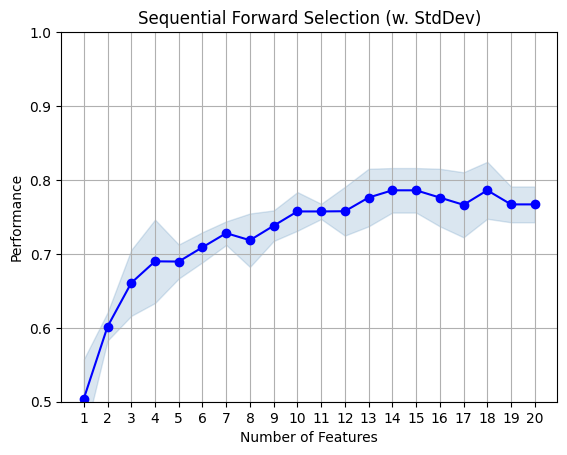

In [34]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection (w. StdDev)')
plt.grid()
plt.show()

From this, we can see that the performance starts to plateau at around 10 features, with peak performance with 14/15 features.

## With Stacking

### Prot

In [ ]:
# from sklearn.feature_selection import SequentialFeatureSelector as SFS

prot_estimators = ['logistic', 'random_forest', 'deep_nn']

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in prot_estimators if x == name)]

# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')
level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])

kf=KFold(n_splits=3)
# define the stacking ensemble
pipe = Pipeline([('data_prep',transformer)])

data_reduced_train['prot'], data_reduced_test['prot'] = train_test_split(data_reduced['prot'], target['prot'], test_size=0.3, train_size=0.7)

data_transformed = pipe.fit_transform(data_reduced['prot'])

sfs = SFS(StackingClassifier(estimator_list, final_estimator=level1, cv=3),
          n_features_to_select=1, 
          direction='forward',
          scoring=make_scorer(f1_score, average='weighted'),
          cv=3, 
          n_jobs=-1)
    
sfs = tqdm(sfs.fit(data_transformed, target['prot']))

#sfs = sequential_forward_selection(StackingClassifier(estimator_list, final_estimator=level1, cv=3), data['prot'], target['prot'], k_features=(5, 10))

In [12]:
print('\nSequential Forward Selection (k=5-10):')

print(sfs.feature_groups_)
sfs.finalize_fit()

pd.DataFrame.from_dict(sfs.get_metric_dict()).T


Sequential Forward Selection (k=5-10):
[[0], [1], [2], [3], [4], [5], [6], [7], [8], [9], [10], [11], [12], [13], [14], [15], [16], [17], [18], [19], [20], [21], [22], [23], [24], [25], [26], [27], [28], [29], [30], [31], [32], [33], [34], [35], [36], [37], [38], [39], [40], [41], [42], [43], [44], [45], [46], [47], [48], [49], [50], [51], [52], [53], [54], [55], [56], [57], [58], [59], [60], [61], [62], [63], [64], [65], [66], [67], [68], [69], [70], [71], [72], [73], [74], [75], [76], [77], [78], [79], [80], [81], [82], [83], [84], [85], [86], [87], [88], [89], [90], [91], [92], [93], [94], [95], [96], [97], [98], [99], [100], [101], [102], [103], [104], [105], [106], [107], [108], [109], [110], [111], [112], [113], [114], [115], [116], [117], [118], [119], [120], [121], [122], [123], [124], [125], [126], [127], [128], [129], [130], [131], [132], [133], [134], [135], [136], [137], [138], [139], [140], [141], [142], [143], [144], [145], [146], [147], [148], [149], [150], [151], [152]

ValueError: attempt to get argmax of an empty sequence

In [19]:
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import matplotlib.pyplot as plt

fig1 = plot_sfs(sfs.get_metric_dict(), kind='std_dev')

plt.ylim([0.5, 1])
plt.title('Sequential Forward Selection with Prot (w. StdDev)')
plt.grid()
plt.show()

AttributeError: SequentialFeatureSelector has not been fitted, yet.

In [ ]:
prot_estimators = ['logistic', 'random_forest', 'deep_nn']

estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in prot_estimators if x == name)]

# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')
level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])

model = StackingClassifier(estimator_list, final_estimator=level1, cv='prefit')

# Sequential Forward Selection
sfs = SFS(knn, 
          k_features=20, 
          forward=True, 
          floating=False, 
          scoring='accuracy',
          cv=3,
          n_jobs=-1)

sfs = sfs.fit(data['prot'], target['prot'])

# Voting Ensemble

In [13]:
def voting_ensemble(estimators, esm_metrics, voting, data, target):
    cv = KFold(n_splits=5, random_state=None, shuffle=True)
    scores = list()

    for train_index, test_index in cv.split(data):
        
        # Spliting into intermediate training and test sets
        x_tr_va, x_test = data.iloc[train_index, :], data.iloc[test_index, :]
        y_tr_va, y_test = target.iloc[train_index], target.iloc[test_index]

        # Spliting training set into training and validation set
        x_train, x_val, y_train, y_val = train_test_split(x_tr_va, y_tr_va, test_size=0.25, random_state=1)

        print('Training base estimators...')
        # Training individual base estimators
        pipes = train_models(estimators, x_train, y_train, transformer)

        # Getting predictions from individual base estimators
        pred, pred_proba = prediction_results(pipes, x_val)

        print('Finding optimal weights...')

        # Finding optimal weights given predictions
        weights = find_weights(estimators, pipes, y_val, pred_proba)

        # Setting up ensemble voting classifier using calculated weights
        ens = Pipeline(steps=[('data_prep',transformer),(modality,VotingClassifier(estimators=estimators, voting = voting, weights = weights))])

        ens.fit(x_train, y_train)

        accuracy_score = ens.score(x_test, y_test)
        
        scores.append(accuracy_score)
    
    print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))    

    # Creating metrics dataframe
    esm_metrics = pd.concat([esm_metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

    return esm_metrics

In [16]:
ensemble_estimators = {}
esm_metrics = pd.DataFrame(columns=col_names)

for modality in datasets:
    ensemble_estimators=[(pipe.steps[1][0],clone(pipe.steps[1][1])) for pipe in pipe_list[modality].values()]
    esm_metrics = voting_ensemble(ensemble_estimators, esm_metrics, 'soft', data[modality], target[modality])


Training base estimators...
Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 56  38 138  68], Accuracy: 0.723
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 57  35 129  79], Accuracy: 0.630
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 53  33 140  74], Accuracy: 0.640
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 63  28 145  64], Accuracy: 0.690
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 56  28 147  69], Accuracy: 0.550


Cross-Validation accuracy: 0.647 +/- 0.059
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 58  38 131  71], Accuracy: 0.860
Training base estimators...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Finding optimal weights...
Training/Test Split Distribution: [ 54  32 133  79], Accuracy: 0.840
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 55  36 139  68], Accuracy: 0.800
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [ 60  32 138  69], Accuracy: 0.859
Training base estimators...
Finding optimal weights...


/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/linear_model/_base.py:441: RuntimeWarning: invalid value encountered in divide
  prob /= prob.sum(axis=1).reshape((prob.shape[0], -1))


Training/Test Split Distribution: [ 59  32 140  68], Accuracy: 0.828


Cross-Validation accuracy: 0.837 +/- 0.022
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 11 17 19], Accuracy: 0.619
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [14 13 15 19], Accuracy: 0.762
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [15  9 17 20], Accuracy: 0.619
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [15 10 19 18], Accuracy: 0.650
Training base estimators...
Finding optimal weights...
Training/Test Split Distribution: [19  8 21 14], Accuracy: 0.250


Cross-Validation accuracy: 0.580 +/- 0.173


In [17]:
esm_metrics

,model,accuracy
0,cnv,0.647 +/- 0.059
1,mrna,0.837 +/- 0.022
2,prot,0.580 +/- 0.173


In [7]:
def trainModel(model, x_train, y_train, n_folds):
    cv = KFold(n_splits= n_folds)
    scores = cross_val_score(model, x_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model, x_train, y_train, cv=cv, method='predict') 
    return scores, y_pred

# Boosting Ensemble

**XGBoost**

In [8]:
def trainBoostModel(x_train, y_train, n_folds):
    cv = KFold(n_splits= n_folds)
    gbm = xgb.XGBClassifier().fit(x_train, y_train)
    
    scores = cross_val_score(gbm, x_train, y_train, scoring='accuracy', cv=cv)
    return scores

In [9]:
cross_val_list = {}
col_names = ['model', 'accuracy']
modality_scores = pd.DataFrame(columns=col_names)

for modality in datasets:
    
    cross_val = pd.DataFrame(columns=col_names)
    predictions = {}

    for name, pipe in pipe_list[modality].items():

        scores, predictions[name] = trainModel(pipe, data[modality], target[modality], 5)
        cross_val = pd.concat([cross_val, pd.DataFrame([[name, "%0.3f +/- %0.3f" % (scores.mean(), scores.std())]], columns=col_names)], ignore_index=True)

    stacked_train = np.column_stack(list(predictions.values()))
    stackModel_scores = trainBoostModel(stacked_train, target[modality], 5)
    modality_scores = pd.concat([modality_scores, pd.DataFrame([[modality, "%0.3f +/- %0.3f" % (stackModel_scores.mean(), stackModel_scores.std())]], columns=col_names)], ignore_index=True)

    cross_val_list[modality] = cross_val

In [10]:
display(cross_val_list['cnv'], cross_val_list['mrna'], cross_val_list['prot'])

,model,accuracy
0,logistic,0.613 +/- 0.047
1,lasso,0.651 +/- 0.053
2,elasticnet,0.581 +/- 0.049
3,random_forest,0.673 +/- 0.062
4,deep_nn,0.585 +/- 0.075


,model,accuracy
0,logistic,0.795 +/- 0.022
1,lasso,0.847 +/- 0.033
2,elasticnet,0.813 +/- 0.045
3,random_forest,0.831 +/- 0.062
4,deep_nn,0.815 +/- 0.018


,model,accuracy
0,logistic,0.669 +/- 0.111
1,lasso,0.717 +/- 0.109
2,elasticnet,0.687 +/- 0.130
3,random_forest,0.620 +/- 0.080
4,deep_nn,0.572 +/- 0.131


In [11]:
modality_scores

,model,accuracy
0,cnv,0.647 +/- 0.061
1,mrna,0.813 +/- 0.048
2,prot,0.572 +/- 0.132


In [ ]:
modality_scores

AdaBoost Classifier (Implement this)

In [22]:
from sklearn.ensemble import AdaBoostClassifier

ADBclf = AdaBoostClassifier(n_estimators = 100, random_state = 0)
scores = ADBclf.fit(data['mrna'], target['mrna'])

In [23]:
ADBclf.score(data['mrna'], target['mrna'])

0.6967871485943775

## Running ensemble with selected features:

In [ ]:
# first, create a custom column selector to select specific columns 
from sklearn.base import BaseEstimator, TransformerMixin

class ColumnSelector(BaseEstimator, TransformerMixin):
    '''select specific columns of a given dataset'''
    def __init__(self, subset):
        self.subset = subset
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X.loc[:, self.subset]

In [11]:
from mlxtend.feature_selection import ColumnSelector
data_reduced = {}

mycols = ['BRE', 'EDC4', 'EIF3B', 'EIF3H', 'EXOC4', 'FAM129B', 'NARFL', 'NCKAP1', 'NELFE', 'NMD3', 'NUDT4', 'PIK3C3', 'PSMC2', 'PSMD2', 'RPRD1B', 'SERPINB1', 'SETD3', 'STAMBP', 'TCERG1', 'UGP2']
pipe = ColumnSelector(mycols)

data_reduced['prot'] = pipe.transform(data['prot'])

data_reduced['prot'] = data['prot'][mycols]

In [20]:
col_names = ['model', 'accuracy']
metrics = pd.DataFrame(columns=col_names)

model, scores = trainStackingModel(estimators, LogisticRegression(), data_reduced['prot'], target['prot'], 5)

metrics = pd.concat([metrics, pd.DataFrame([[modality, '%.3f +/- %.3f' %(np.mean(scores), np.std(scores))]], columns=col_names)], ignore_index=True)

/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/Users/signehoel/comp401/sklearn-venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:679: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged ye

In [21]:
metrics

,model,accuracy
0,prot,0.620 +/- 0.189


# Mega-Ensemble

In [8]:
# Dictionary of best estimators for each modality
selected_estimators = {
    'cnv': ['logistic', 'xgb', 'deep_nn'],
    'mrna': ['logistic', 'deep_nn'],
    'prot': ['logistic', 'elasticnet']
}

In [9]:
def trainModel(model, x_train, y_train, n_folds):
    cv = KFold(n_splits= n_folds, random_state=1)
    scores = cross_validate(model, x_train, y_train, scoring=_metrics, cv=cv, n_jobs=-1)
    y_pred = cross_val_predict(model, x_train, y_train, cv=cv, method='predict') 
    return scores, y_pred

In [10]:
read_data = {}
read_data['cnv'] = pd.read_pickle("cnv_reduced.pkl")
read_data['mrna'] = pd.read_pickle("mrna_reduced.pkl")
read_data['prot'] = pd.read_pickle("prot_reduced.pkl")

In [11]:
# Merge the data frames by the common index
data_merged = pd.merge(read_data['cnv'], read_data['mrna'].iloc[:, :1100], left_index=True, right_index=True)
data_merged = pd.merge(data_merged, read_data['prot'], left_index=True, right_index=True)
# Merge the data frames by the common index
target_merged = pd.merge(target['cnv'], target['mrna'], left_index=True, right_index=True)
target_merged = pd.merge(target_merged, target['prot'], left_index=True, right_index=True)

In [12]:
x_merged = {}
y_merged = {}
x_merged['cnv'] = data_merged.iloc[:, :4000]
x_merged['mrna'] = data_merged.iloc[:, 4000:5100]
x_merged['prot'] = data_merged.iloc[:, 5100:6800]
y_merged['cnv'] = target_merged.iloc[:, 0]
y_merged['mrna'] = target_merged.iloc[:, 1]
y_merged['prot'] = target_merged.iloc[:, 2]

In [13]:
x_merged['prot']

,KRT7,PGLYRP1,MYL12B_y,PM20D2_y,CLC,TIPIN,OGFOD3_y,UCHL1,LALBA,APPBP2,...,CLIC3,COL5A2,CEP97,CEP68,CCDC174,CCDC43_y,CCDC6,CCDC61,CCDC64B_y,CCDC8
TCGA-A2-A0CM,-0.252781,-0.652407,-0.458958,0.466743,-0.804091,-0.168741,-0.142518,0.512100,-2.628424,-0.036513,...,1.213030,0.091136,-0.025976,-0.318504,0.490197,-0.025280,-0.032032,-0.107731,1.004624,-0.063571
TCGA-A2-A0D0,-0.859379,1.245757,1.655324,1.079847,1.974396,-1.752400,0.816740,0.863305,-1.511417,1.040766,...,0.163853,-1.063527,-0.977139,-0.651553,1.015809,-1.175857,-0.583200,0.808520,-0.776157,-3.061733
TCGA-A2-A0D1,-0.951058,-2.206286,1.468337,-2.054043,-0.708302,1.664259,0.241013,-0.817346,-1.951375,0.268673,...,-0.087111,-0.376770,-0.316669,-2.303263,1.120176,-1.714018,-0.492726,0.430449,-0.802229,-1.243608
TCGA-A2-A0D2,-0.567193,-0.311477,-0.058518,0.595648,-0.537435,0.299439,0.125524,-0.571720,-2.584327,-0.338144,...,-0.402826,0.281776,0.155579,-0.338223,0.063009,0.121584,0.036171,-0.093096,-0.588578,0.485521
TCGA-A2-A0EQ,-0.630218,-0.865866,-0.587042,-0.651174,1.358506,-0.112551,-0.154029,-0.075283,-2.260237,-0.237436,...,-0.270774,-0.438922,-0.143363,-0.670775,0.005408,-0.176620,0.139030,-0.337895,-0.669885,-0.352879
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-E2-A150,-0.062429,-0.231925,1.052740,0.499366,-0.600886,-1.330044,-1.365431,-0.793046,-1.823209,-0.130041,...,0.270114,-0.485456,0.740438,0.154211,-0.241471,-1.104169,-0.513908,-1.163599,-0.189928,-0.630504
TCGA-E2-A154,-0.818751,-2.027370,0.536328,-0.819021,-1.478825,-0.753507,-0.606596,0.030430,-2.293922,-0.138039,...,-0.219075,0.511677,0.367595,-0.505229,0.015657,-0.155406,-0.319213,0.630121,-0.062637,-0.260390
TCGA-E2-A158,-0.322649,-2.095276,-1.150418,0.779039,-1.703908,-0.730526,0.398101,1.534247,-2.101025,-0.727052,...,0.465464,-0.833423,-0.109132,0.311638,0.464657,-0.295954,-0.074305,-0.300610,0.482378,-0.222239
TCGA-E2-A159,1.145766,0.241650,1.849917,-0.253258,-0.091916,1.687692,1.093552,-0.600469,-1.208610,0.767249,...,0.511684,-0.285383,0.962732,-0.428801,-0.313495,-0.766961,-0.395624,-0.484622,0.738032,-3.252025


In [15]:
predictions = {}

# Create the transformer to impute missing values
imputer = SimpleImputer(strategy='mean')

level1 = Pipeline(steps=[('prep', imputer), ('lr', LogisticRegression())])
scores = {}

col_names = ['model', 'f1_score', 'accuracy']

modality_scores = pd.DataFrame(columns=col_names)

for modality in tqdm(datasets):
    cv = KFold(n_splits=5, random_state=1, shuffle=True)
    
    estimator_list = [(name, estimator) for (name, estimator) in estimators if any(x for x in selected_estimators[modality] if x == name)]
    model = Pipeline(steps=[('data_prep',transformer),('stacking',StackingClassifier(estimators=estimator_list, final_estimator=level1, cv=cv))])
    # define the stacking ensemble
    #model = StackingClassifier(estimators=estimator_list, final_estimator=level1, cv=cv)
    predictions[modality] = cross_val_predict(model, x_merged[modality], y_merged[modality], cv=cv, method='predict')
    scores[modality] = cross_validate(model, x_merged[modality], y_merged[modality], cv=cv, scoring=_metrics)
    
    modality_scores = pd.concat([modality_scores, pd.DataFrame([[modality, "%0.3f +/- %0.3f" % (scores[modality]['test_f1'].mean(), scores[modality]['test_f1'].std()), "%0.3f +/- %0.3f" % (scores[modality]['test_accuracy'].mean(), scores[modality]['test_accuracy'].std())]], columns=col_names)], ignore_index=True)
    

100%|██████████| 3/3 [02:08<00:00, 42.87s/it]


In [16]:
modality_scores

,model,f1_score,accuracy
0,cnv,0.694 +/- 0.062,0.699 +/- 0.056
1,mrna,0.868 +/- 0.058,0.865 +/- 0.063
2,prot,0.748 +/- 0.142,0.768 +/- 0.111


In [17]:
def trainBoostModel(x_train, y_train, n_folds, seed):
    cv = KFold(n_splits= n_folds, random_state=seed, shuffle=True)
    gbm = XGBClassifier(
     n_estimators= 2000,
     max_depth= 4,
     min_child_weight= 2,
     gamma=0.9,                        
     subsample=0.8,
     colsample_bytree=0.8,
        objective='multi:softprob', 
        random_state=1)
    
    scores = cross_validate(gbm, x_train, y_train, scoring=_metrics, cv=cv)
    
    return scores

In [18]:
esm_train = np.column_stack(list(predictions.values()))

stackModel_scores = trainBoostModel(esm_train, y_merged[modality], 5, 1)

print('F1: %.3f +/- %.3f' %(np.mean(stackModel_scores['test_f1']), np.std(stackModel_scores['test_f1'])))
print('Accuracy: %.3f +/- %.3f' %(np.mean(stackModel_scores['test_accuracy']), np.std(stackModel_scores['test_accuracy'])))

F1: 0.830 +/- 0.060
Accuracy: 0.826 +/- 0.063


In [19]:
modalities=['cnv', 'mRNA', 'prot', 'boosting']
scorers = []
scorers.append(scores['cnv'])
scorers.append(scores['mrna'])
scorers.append(scores['prot'])
scorers.append(stackModel_scores)

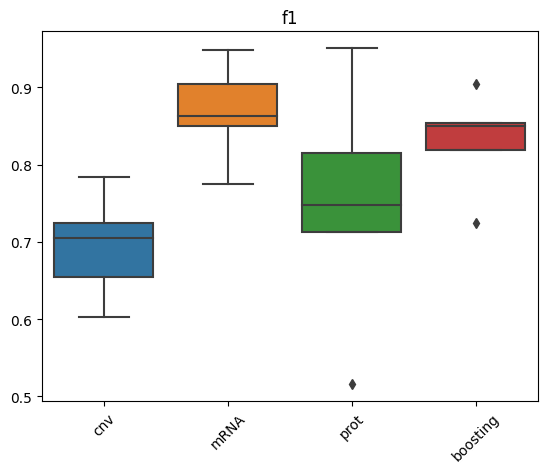

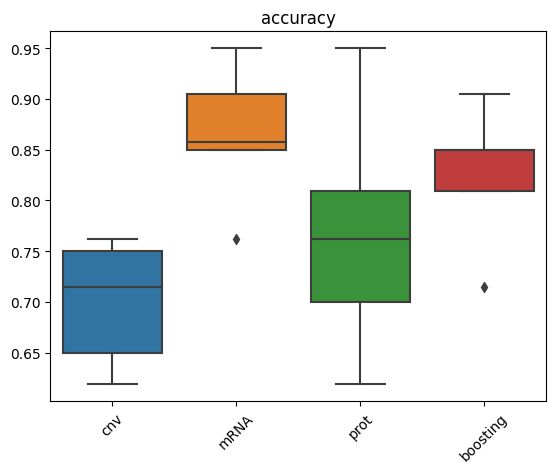

In [20]:
plot_scores(modalities, scorers)